## ANALYZING THE EFFECT OF TEXT FEATURES ON DETERMINING THE PERIOD TO WHICH THE BOOK BELONGS - PERIOD_GENRE_CLASSIFICATION <br>
### THE QUESTION IS : To the readers in search of books in the range of particular time period, could the text description available be useful or not?

In [ ]:
!pip install nltk
!pip install gensim

In [3]:
# import libraries
import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)
import gensim.downloader
#glove_vectors = gensim.downloader.load('glove-twitter-25')
from gensim.models import Phrases
from gensim.models import KeyedVectors
from gensim.test.utils import common_texts
from gensim.models import Word2Vec
#import shap
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import LinearSVC
#from sklearn.naive_bayes import MultinomialNB
from sklearn.ensemble import AdaBoostClassifier
from sklearn.tree import DecisionTreeClassifier
import nltk
nltk.download("stopwords")
from nltk.corpus import stopwords
nltk.download('averaged_perceptron_tagger')
#from catboost import Pool, CatBoostRegressor
from sklearn.metrics import roc_auc_score,confusion_matrix, accuracy_score,recall_score,precision_score,f1_score,classification_report
from sklearn.model_selection import train_test_split,cross_val_score
from sklearn.preprocessing import LabelEncoder
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer
import re
import string
import warnings 
warnings.filterwarnings("ignore")

pd.set_option('display.max_rows', 1000)

[nltk_data] Downloading package stopwords to /usr/share/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /usr/share/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!


In [4]:
from sklearn.preprocessing import StandardScaler

In [5]:
from sklearn import svm

In [6]:
import os
file_list = []
for dirname, _, filenames in os.walk('/kaggle/input'):
    for filename in filenames:
        if filename.startswith('book'):
            file_list.append(os.path.join(dirname, filename))

df = pd.read_csv(file_list[0])
# rename columns to sentence case
df.rename(columns={c:c.title() for c in df.columns}, inplace=True)
for filename in file_list[1:]:
    df_tmp = pd.read_csv(filename)
    df_tmp.rename(columns={c:c.title() for c in df_tmp.columns}, inplace=True)
    df = pd.concat([df, df_tmp])
    print(df.shape)
# drop duplicated records
df.drop_duplicates(inplace=True)
print(df.shape)
df.head().T

(90025, 20)
(346620, 20)
(402802, 20)
(446363, 20)
(496206, 20)
(535069, 20)
(575959, 20)
(630232, 20)
(685388, 20)
(740247, 20)
(772352, 20)
(812057, 20)
(869103, 20)
(1265060, 20)
(1306952, 20)
(1362107, 20)
(1400395, 20)
(1433381, 20)
(1491673, 20)
(1526432, 20)
(1806688, 20)
(1850310, 20)
(1850198, 20)


,0,1,2,3,4
Ratingdist4,4:10,4:1,4:23,4:5969,4:15
Ratingdist1,1:2,1:0,1:0,1:278,1:2
Isbn,080959577X,1402158718,1598180339,0613607406,0859537803
Authors,Mrs. Henry Wood,Mrs. Henry Wood,Mrs. Henry Wood,Celia Rees,Arden Druce
Id,300002,300005,300007,300008,300009
Pagesnumber,487,310,380,261,32
Language,eng,NaN,NaN,NaN,NaN
Ratingdist3,3:5,3:1,3:11,3:4461,3:14
Name,The Channings,"William Allair; Or, Running Away To Sea",Anne Hereford,Witch Child,"Witch, Witch Come To My Party"
Publishyear,2004,2005,2006,2002,1991


In [7]:
df_2=df[~df['Description'].isna()]
df=df_2.copy()

In [8]:
df_2.describe().columns
#numerical columns

Index(['Id', 'Pagesnumber', 'Publishyear', 'Countsofreview', 'Publishmonth',
       'Publishday', 'Rating', 'Count Of Text Reviews'],
      dtype='object')

In [9]:
df_2.columns

Index(['Ratingdist4', 'Ratingdist1', 'Isbn', 'Authors', 'Id', 'Pagesnumber',
       'Language', 'Ratingdist3', 'Name', 'Publishyear', 'Countsofreview',
       'Ratingdist5', 'Publishmonth', 'Ratingdist2', 'Publishday',
       'Ratingdisttotal', 'Rating', 'Publisher', 'Description',
       'Count Of Text Reviews'],
      dtype='object')

considering that dataset is updated every 2 days, only till the year 2022 could be valid

In [ ]:
sorted(df_2['Publishyear'])[:-20]

In [10]:
sorted_yrs_gt_1000=sorted([2007, 2006, 2005, 2008, 2004, 2003, 2002, 2000, 2001, 1999, 1998,
            1997, 1996, 1995, 1994, 1993, 1992, 1991, 1990, 1989, 1988, 1987,
            1986, 2009, 1985, 1984, 1983, 1982, 1981, 1980, 1979, 2010, 1978,
            1977, 1976, 2011, 1975, 1974, 1973, 1972, 2012, 1971, 1970, 2013,
            2014, 2015, 1969])
df_2['Publishyear'].value_counts().loc[sorted_yrs_gt_1000]

1969      1201
1970      1862
1971      2025
1972      2135
1973      2312
1974      2506
1975      2726
1976      3007
1977      3698
1978      3847
1979      3940
1980      4654
1981      5214
1982      5947
1983      6595
1984      7764
1985      9378
1986     10667
1987     13252
1988     14567
1989     17145
1990     20879
1991     23514
1992     27464
1993     29265
1994     32412
1995     37314
1996     41342
1997     48657
1998     52733
1999     53462
2000     57941
2001     57558
2002     62024
2003     69108
2004     70241
2005     77625
2006     78002
2007    101654
2008     72725
2009     10086
2010      3922
2011      2936
2012      2110
2013      1809
2014      1560
2015      1468
Name: Publishyear, dtype: int64

In [11]:
df_2=df_2[df_2['Publishyear'].isin(sorted_yrs_gt_1000)]
df_2['Publishyear'].unique()

array([2003, 1979, 2000, 1999, 2001, 2006, 2010, 1990, 1997, 2007, 2002,
       2004, 1998, 2005, 2008, 1996, 1989, 1995, 1985, 1980, 1994, 2009,
       1993, 1986, 2015, 1992, 1988, 1983, 1991, 1987, 1982, 1974, 1972,
       2013, 1975, 2011, 1977, 2012, 1978, 1984, 1981, 1970, 1969, 1973,
       1971, 1976, 2014])

In [12]:
df_2.loc[df_2['Publishyear'].between(1969, 1979, 'both'), 'age'] = 'seventies'
df_2.loc[df_2['Publishyear'].between(1979, 1989, 'right'), 'age'] = 'eighties'
df_2.loc[df_2['Publishyear'].between(1989, 1999, 'right'), 'age'] = 'nineties'
df_2.loc[df_2['Publishyear'].between(1999, 2015, 'right'), 'age'] = 'twoK'
df_2.head(5)

,Ratingdist4,Ratingdist1,Isbn,Authors,Id,Pagesnumber,Language,Ratingdist3,Name,Publishyear,...,Ratingdist5,Publishmonth,Ratingdist2,Publishday,Ratingdisttotal,Rating,Publisher,Description,Count Of Text Reviews,age
0,4:1,1:0,0972494421,Judith Kleinfeld,1500001,192,NaN,3:0,Go For It!: Finding Your Own Frontier,2003,...,5:0,1,2:1,9,total:2,3.00,Epicenter Press,In the wake of national tragedies and an econo...,0.0,twoK
1,4:15,1:0,0809308657,Gerald R. Kleinfeld,1500002,464,NaN,3:5,Hitler's Spanish Legion: The Blue Division in ...,1979,...,5:6,1,2:1,6,total:27,3.96,Southern Illinois University Press,"Though well publicized in Europe, and with eno...",2.0,seventies
2,4:0,1:0,0872241289,Denis A. Kleinfeld,1500003,1735,NaN,3:0,"Practical International Tax Planning, 4th Ed (...",2000,...,5:0,1,2:0,12,total:0,0.00,Practising Law Institute,"As globalisation accelerates, more tax-advanta...",0.0,twoK
3,4:0,1:0,0195644239,Indira Ghose,1500010,316,NaN,3:1,Memsahibs Abroad: Writings by Women Travellers...,1999,...,5:0,19,2:0,8,total:1,3.00,"Oxford University Press, USA",This exciting anthology provides the best of t...,0.0,nineties
4,4:0,1:0,0195655311,Indira Chowdhury,1500011,208,NaN,3:0,The Frail Hero and Virile History: Gender and ...,2001,...,5:0,31,2:0,7,total:0,0.00,Not Avail,Demonstrating the centrality of gender in the ...,0.0,twoK


In [13]:
df_2.age.unique()

array(['twoK', 'seventies', 'nineties', 'eighties'], dtype=object)

In [14]:
df=df_2.copy()

<a id="section-transform"></a>
<h1 style='background:#dfd873;color:blue'>Data transformation</h1>

In [15]:
# select label
main_label = 'Rating'
# select books published during years 1900-2022
#df = df[(df['Publishyear']>=1900)&(df['Publishyear']<=2022)]
# select books with average rating >= 1
df_2 = df_2[df_2[main_label]>=1]
# select books rated by at least 10 times
df_2['num_ratings'] = df_2['Ratingdisttotal'].apply(lambda x: int(x.lstrip('total:')))
df_2 = df_2[df_2['num_ratings']>=10]
# select books with <= 4000 pages
df_2 = df_2[df_2['Pagesnumber']<=4000]
# replace authors with Other based on the dictionary 
authors_list = ['Anonymous', 
                'Unknown', 
                'National Research Council', 
                'Cram101 Textbook Reviews', 
                'Fodor\'s Travel Publications Inc.',
                'Various', 
                'Walt Disney Company', 
                'Hal Leonard Publishing Company', 
                'NOT A BOOK', 
                'Time-Life Books', 
                'Alfred A. Knopf Publishing Company', 
                'Reader\'s Digest Association']
df_2['Authors'] = df_2['Authors'].map({c:'Other' for c in authors_list}).fillna(df_2['Authors'])
# replace languages based on the dictionary
lang_dict = {'en-US': 'eng', 
             'en-GB': 'eng', 
             'en-CA': 'eng'}
df_2['Language'] = df_2['Language'].map(lang_dict).fillna(df_2['Language'])
# replace publishers based on the dictionary
pub_dict = {'Wiley': 'John Wiley & Sons', 
            'Wiley-Blackwell': 'John Wiley & Sons',
            'Not Avail': 'Other'}
df_2['Publisher'] = df_2['Publisher'].map(pub_dict).fillna(df_2['Publisher'])
# bin pages numbers on larger buckets
#df_2['Pagesnumber'] = df_2['Pagesnumber'].apply(lambda x: int(100*round(1/100*x)))
# convert published year to decade
#df_2['Decade'] = df_2['Publishyear'].apply(lambda x: str(x//10)+'0s')
# drop unused columns
cols2drop = ['Id', 'Name', 'Publishmonth', 'Publishday', 'Publishyear', 'Rating',
             'Ratingdist1', 'Ratingdist2', 'Ratingdist3', 'Ratingdist4', 'Ratingdist5', 
             'Isbn', 'Ratingdisttotal', 'Count Of Text Reviews', 
             'Countsofreview', 'num_ratings']#Id', 'Pagesnumber', 'Publishyear', 'Countsofreview', 'Publishmonth',
     #  'Publishday', 'Rating', 'Count Of Text Reviews'
df_2 = df_2.drop(cols2drop, axis=1)
# set up the rare label encoder limiting number of categories to max_n_categories
for col in ['Authors', 'Publisher', 'Language','age']:
    df_2[col] = df_2[col].fillna('None')
    encoder = LabelEncoder()
    df_2[col] = encoder.fit_transform(df_2[[col]])
print(df_2.shape)

(491768, 6)


In [16]:
df_2.loc[df_2['Pagesnumber'].between(0, 900, 'both'), 'type'] = 'short stories and short novels'
df_2.loc[df_2['Pagesnumber'].between(1000, 1999, 'both'), 'type'] = 'long novels'
df_2.loc[df_2['Pagesnumber'].between(2000, 2999, 'both'), 'type'] = 'longer novels'
df_2.loc[df_2['Pagesnumber'].between(3000, 4000, 'both'), 'type'] = 'very longer novels'
df_2.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 491768 entries, 1 to 43620
Data columns (total 7 columns):
 #   Column       Non-Null Count   Dtype 
---  ------       --------------   ----- 
 0   Authors      491768 non-null  int64 
 1   Pagesnumber  491768 non-null  int64 
 2   Language     491768 non-null  int64 
 3   Publisher    491768 non-null  int64 
 4   Description  491768 non-null  object
 5   age          491768 non-null  int64 
 6   type         490029 non-null  object
dtypes: int64(5), object(2)
memory usage: 30.0+ MB


In [17]:
encoder.inverse_transform([0,1,2,3])

array(['eighties', 'nineties', 'seventies', 'twoK'], dtype=object)

In [18]:
#encoder.inverse_transform([0,1,2,3])
# output: array(['eighties', 'nineties', 'seventies', 'twenties'], dtype=object)
le=LabelEncoder()
df_2['type']=le.fit_transform(df_2['type'])
le.inverse_transform([0,1,2,3])
#array(['long novels', 'longer novels', 'short stories and short novels',
 #      'very longer novels'], dtype=object)

array(['long novels', 'longer novels', 'short stories and short novels',
       'very longer novels'], dtype=object)

In [19]:
le.inverse_transform([0,1,2,3,4])

array(['long novels', 'longer novels', 'short stories and short novels',
       'very longer novels', nan], dtype=object)

In [ ]:
#sorted(df_2['Pagesnumber'].unique())

In [ ]:
#df_2['short_desc']=df_2['Description'].apply(lambda x:x[:300])
#df_2['short_desc']

In [20]:
#set(range(0,491768))-set(df_2['Description'].index)
df_2.reset_index(drop=True,inplace=True)
set(range(0,491768))-set(df_2['Description'].index)

set()

<AxesSubplot:>

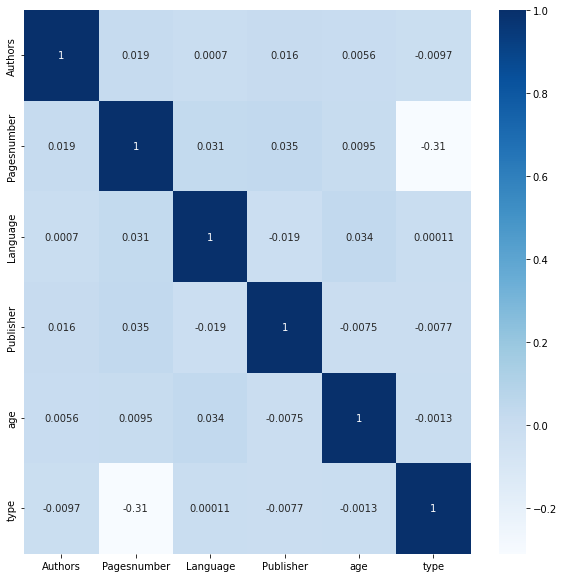

In [21]:
plt.figure(figsize=(10,10))
sns.heatmap(df_2.corr(),annot=True,cmap='Blues')

In [22]:
df_2['type'].value_counts()

2    485290
0      4197
4      1739
1       481
3        61
Name: type, dtype: int64

In [30]:
df=df_2.copy()

In [23]:
df_2=pd.concat((df_2[df_2['type']==1].head(400),df_2[df_2['type']==2].head(400),df_2[df_2['type']==0].head(400)),axis=0)
df_2.reset_index(drop=True,inplace=True)
df_2

,Authors,Pagesnumber,Language,Publisher,Description,age,type
0,17789,2704,1,12426,"Newly revised and updated, this comprehensive,...",3,1
1,50134,2100,1,14157,THE AMERICAN TRADITION IN LITERATURE has intro...,1,1
2,66625,2208,1,14157,*This description refers to the single-volume ...,1,1
3,113002,2088,1,24587,<i>Women of Faith Study Bible</i> offers a fem...,3,1
4,26449,2141,1,10019,This ninth edition includes the latest vocabul...,3,1
...,...,...,...,...,...,...,...
1195,150190,1024,1,20474,Accounting is increasingly becoming an informa...,1,0
1196,150796,1088,25,13065,Wassili Grossmans Gesellschaftsepos über die S...,3,0
1197,122305,1088,1,16063,A large variety and quantity of up-to-date app...,3,0
1198,54381,1038,1,20713,Herbert George Wells was perhaps best known as...,0,0


In [24]:
df_2.age.value_counts()

3    771
1    332
0     70
2     27
Name: age, dtype: int64

In [25]:
x=df_2[['Description','Pagesnumber','age','Language','Authors','Publisher']]
y=df_2['type'].values
x_train,x_test,y_train,y_test=train_test_split(x,y,shuffle=True,stratify=y)
print(len(x_train),len(x_test),len(y_train),len(y_test))

900 300 900 300


'''x=df_2[['Description','Pagesnumber','age','Language','Authors','Publisher']]
y=df_2['type'].values
x_train,x_test,y_train,y_test=train_test_split(x,y,shuffle=True,stratify=y)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))
x_train,x_test,y_train,y_test=train_test_split(x_train,y_train,shuffle=True,stratify=y_train)
print(len(x_train),len(x_test),len(y_train),len(y_test))'''

In [26]:
for i in x_train['Description'].index:
    tmp=""
    if type(x_train['Description'][i]=='str'): 
        tmp=x_train['Description'][i]
    else:
        for j in range(len(x_train['Description'][i])):
            tmp+=x_train['Description'][i].values[j]+" "
    x_train['Description'].loc[i]=tmp[:500]

In [27]:
for i in x_test['Description'].index:
    tmp=""
    if type(x_test['Description'][i]=='str'): 
        tmp=x_test['Description'][i]
    else:
        for j in range(len(x_test['Description'][i])):
            tmp+=x_test['Description'][i].values[j]+" "
    x_test['Description'].loc[i]=tmp[:500]

In [28]:
x_test['Description'][i]

'A great choice for helping you apply biblical truths to your life• over 10,000 of in-text application notes• over 100 personality profiles• in the most literal word-for-word translationThe study Bible that helps you translate Scriptural truths into practical actionThe Life Application Study Bible was created for the reader who wants to answer the question, “What does God’s Word mean for my life today?” This edition is full of features that will help you understand the timeless lessons of the Bib'

<a id="section-model"></a>
<h1 style='background:#f3f873;color:magenta'>Machine learning</h1>

In [29]:
x_train.shape

(900, 6)

In [30]:
X=np.concatenate((x_train['Description'].values,x_test['Description'].values),axis=0)
#print(y_train)

In [31]:
x_test.shape

(300, 6)

In [32]:
X.shape

(1200,)

In [34]:
cvec=CountVectorizer(analyzer='word', ngram_range=(2, 2),max_features=1000)
cv_trans=cvec.fit_transform(X)
cv_trans.toarray()

array([[0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       ...,
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 0],
       [0, 0, 0, ..., 0, 0, 1]])

In [35]:
pd.DataFrame(data=cv_trans.toarray(),columns=cvec.get_feature_names())

,000 entries,000 in,000 new,000 study,10 000,100 000,16 new,16 pages,20 000,300 new,...,years to,you are,you can,you have,you ll,you need,you to,you want,you will,your life
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,2,1,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1195,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1196,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1197,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1198,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [36]:
x_tr_cv=cv_trans.toarray()[:900,:]
x_te_cv=cv_trans.toarray()[900:,:]

In [37]:
scaler = StandardScaler()
std_x_tr=scaler.fit_transform(x_train[['Pagesnumber','age','Language','Authors','Publisher']].to_numpy())
std_x_tr

array([[ 0.83465455, -0.22549925, -0.44087278, -0.6383759 , -1.35289118],
       [-1.24362911,  0.73180889, -0.44087278, -0.21472296,  1.39534493],
       [-1.22049851,  0.73180889, -0.44087278, -1.55168293, -0.30650797],
       ...,
       [-0.2386049 , -1.18280739, -0.44087278, -0.85418955, -0.44972219],
       [-0.19350025, -1.18280739, -0.44087278,  0.98667267, -1.17136577],
       [-0.33112727, -0.22549925,  0.83564895, -1.31314116,  0.41207072]])

In [38]:
std_x_te=scaler.fit_transform(x_test[['Pagesnumber','age','Language','Authors','Publisher']].to_numpy())
std_x_te

array([[ 0.6199174 ,  0.68133929, -0.36399793,  0.56384   ,  0.36613274],
       [-0.31660021,  0.68133929, -0.36399793, -0.70411603,  1.44966222],
       [-1.39900749,  0.68133929, -0.36399793, -0.28942413, -0.88670286],
       ...,
       [ 1.02582013,  0.68133929, -0.36399793, -1.57582189, -0.54083255],
       [-1.09193325, -1.23792631, -0.36399793,  0.25594207, -1.48823577],
       [ 1.51055034,  0.68133929, -0.36399793,  0.56384   ,  1.61704272]])

In [39]:
x_tr_prep=np.concatenate((std_x_tr,x_tr_cv),axis=1)
x_te_prep=np.concatenate((std_x_te,x_te_cv),axis=1)

In [40]:
x_tr_prep.shape

(900, 1005)

In [41]:
from sklearn.model_selection import GridSearchCV
clf_svc = GridSearchCV(svm.SVC(gamma='auto'),{
    'C':[1,5,10,15,20,30,50],
    'kernel': ['rbf','linear','sigmoid','poly'],
    'max_iter':[1,5,10,20,100]
}, cv= 5)
clf_svc.fit(x_tr_prep[:,-1000:],y_train)

GridSearchCV(cv=5, estimator=SVC(gamma='auto'),
             param_grid={'C': [1, 5, 10, 15, 20, 30, 50],
                         'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
                         'max_iter': [1, 5, 10, 20, 100]})

In [42]:
print(clf_svc.best_params_)
print(clf_svc.best_score_)

{'C': 15, 'kernel': 'sigmoid', 'max_iter': 100}
0.538888888888889


In [43]:
clf_svc_2 = GridSearchCV(svm.SVC(gamma='auto'),{
    'C':[1,5,10,15,20,30,50],
    'kernel': ['rbf','linear','sigmoid','poly'],
    'max_iter':[1,5,10,20,100]
}, cv= 5)
clf_svc_2.fit(x_tr_prep[:,:],y_train)
print(clf_svc_2.best_params_)
print(clf_svc_2.best_score_)

{'C': 50, 'kernel': 'rbf', 'max_iter': 100}
0.9755555555555555


In [44]:
clf_lr=GridSearchCV(LogisticRegression(random_state=0,max_iter=200),{'solver':['newton-cg','sag','saga','lbfgs']},cv=5)
clf_lr.fit(x_tr_prep[:,-1000:],y_train)
print(clf_lr.best_params_)
print(clf_lr.best_score_)
#clf_rf=RandomForestClassifier(n_estimators=300, max_depth=5, random_state=1)

{'solver': 'newton-cg'}
0.5911111111111111


In [45]:
clf_lr_2=GridSearchCV(LogisticRegression(random_state=0,max_iter=200),{'solver':['newton-cg','sag','saga','lbfgs']},cv=5)
clf_lr_2.fit(x_tr_prep[:,:],y_train)
print(clf_lr_2.best_params_)
print(clf_lr_2.best_score_)

{'solver': 'newton-cg'}
0.9644444444444444


In [46]:
clf_rf=GridSearchCV(RandomForestClassifier(n_estimators=300),{'max_depth':[3,4,5],
                                                              'max_features':['sqrt','log2'],
                                                              'criterion':['gini','entropy','logloss']},cv=5)
clf_rf.fit(x_tr_prep[:,-1000:],y_train)
print(clf_rf.best_params_)
print(clf_rf.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2'}
0.5755555555555556


In [47]:
clf_rf_2=GridSearchCV(RandomForestClassifier(n_estimators=300),{'max_depth':[3,4,5],
                                                              'max_features':['sqrt','log2'],
                                                              'criterion':['gini','entropy','logloss']},cv=5)
clf_rf_2.fit(x_tr_prep[:,:],y_train)
print(clf_rf_2.best_params_)
print(clf_rf_2.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt'}
0.8533333333333335


## COUNT VECTORIZER SCORES

In [48]:
def pl_confuse(actual_class,pred_class):
    plt.figure(figsize = (18,8))
    sns.heatmap(confusion_matrix(actual_class, pred_class), annot = True, xticklabels = np.unique(actual_class), yticklabels = np.unique(actual_class), cmap = 'summer')
    plt.xlabel('Predicted Labels')
    plt.ylabel('True Labels')
    plt.show()
def print_metrics(actual_class,pred_class,average="macro"):
    unique_class = set(actual_class)
    roc_auc_dict = dict()
    for per_class in unique_class:
        
        #creating a list of all the classes except the current class 
        other_class = [x for x in unique_class if x != per_class]

        #marking the current class as 1 and all other classes as 0
        new_actual_class = [0 if x in other_class else 1 for x in actual_class]
        new_pred_class = [0 if x in other_class else 1 for x in pred_class]

        #using the sklearn metrics method to calculate the roc_auc_score
        roc_auc = roc_auc_score(new_actual_class, new_pred_class, average = average)
        roc_auc_dict[per_class] = roc_auc
    print(f'ROC_AUC_DICT = {roc_auc_dict}\n','*'*40)
    print("f1_score macro = ", f1_score(actual_class,pred_class,average="macro"),"\n","*"*50)
    print("f1_score micro (or accuracy) = ", f1_score(actual_class,pred_class,average="micro"),"\n","*"*50)
    cm = confusion_matrix(actual_class, pred_class)
    #pl_confuse(actual_class,cm)
    recall = recall_score(actual_class,pred_class,average='weighted') # np.diag(cm) / np.sum(cm, axis = 1)
    precision = precision_score(actual_class,pred_class,average='weighted')  #np.diag(cm) / np.sum(cm, axis = 0)
    print("PRECISION = ",precision," AVERAGED PRECSION = ",np.mean(precision),"\n","*"*50)
    print("RECALL = ",recall," AVERAGED RECALL = ",np.mean(recall),"\n","*"*50)
    print(classification_report(actual_class,pred_class),"\n","*"*50)
    pl_confuse(actual_class,pred_class)

ROC_AUC_DICT = {0: 0.6275000000000001, 1: 0.7125000000000001, 2: 0.7975}
 ****************************************
f1_score macro =  0.5965649236576813 
 **************************************************
f1_score micro (or accuracy) =  0.6166666666666667 
 **************************************************
PRECISION =  0.642729065805989  AVERAGED PRECSION =  0.642729065805989 
 **************************************************
RECALL =  0.6166666666666667  AVERAGED RECALL =  0.6166666666666667 
 **************************************************
              precision    recall  f1-score   support

           0       0.59      0.39      0.47       100
           1       0.77      0.50      0.61       100
           2       0.57      0.96      0.71       100

    accuracy                           0.62       300
   macro avg       0.64      0.62      0.60       300
weighted avg       0.64      0.62      0.60       300
 
 **************************************************


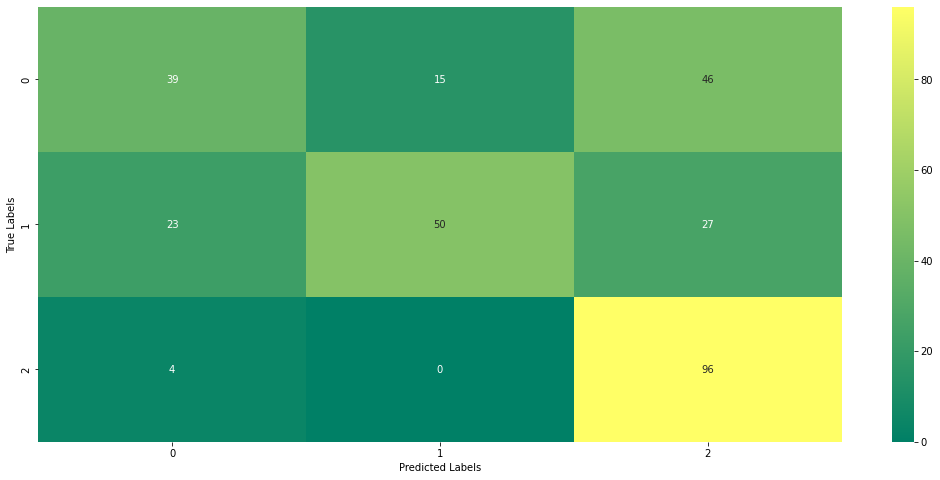

In [49]:
y_rf_hat=clf_rf.predict(x_te_prep[:,-1000:])
print_metrics(y_test,y_rf_hat)

ROC_AUC_DICT = {0: 0.605, 1: 0.7424999999999999, 2: 0.8050000000000002}
 ****************************************
f1_score macro =  0.6160406259903718 
 **************************************************
f1_score micro (or accuracy) =  0.6233333333333333 
 **************************************************
PRECISION =  0.6134739560912613  AVERAGED PRECSION =  0.6134739560912613 
 **************************************************
RECALL =  0.6233333333333333  AVERAGED RECALL =  0.6233333333333333 
 **************************************************
              precision    recall  f1-score   support

           0       0.50      0.42      0.46       100
           1       0.65      0.66      0.66       100
           2       0.69      0.79      0.73       100

    accuracy                           0.62       300
   macro avg       0.61      0.62      0.62       300
weighted avg       0.61      0.62      0.62       300
 
 **************************************************


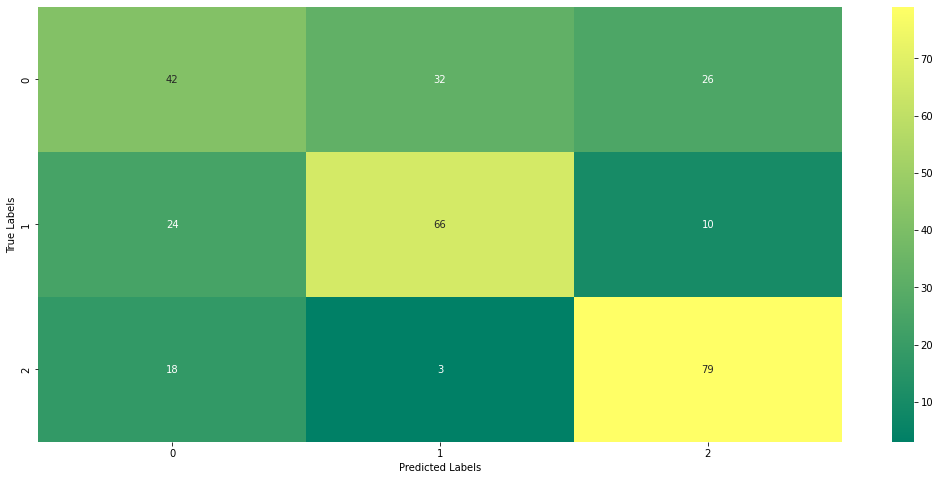

In [50]:
y_lr_hat=clf_lr.predict(x_te_prep[:,-1000:])
print_metrics(y_test,y_lr_hat)

ROC_AUC_DICT = {0: 0.5499999999999999, 1: 0.7125, 2: 0.725}
 ****************************************
f1_score macro =  0.5011635681040911 
 **************************************************
f1_score micro (or accuracy) =  0.55 
 **************************************************
PRECISION =  0.590831090831091  AVERAGED PRECSION =  0.590831090831091 
 **************************************************
RECALL =  0.55  AVERAGED RECALL =  0.55 
 **************************************************
              precision    recall  f1-score   support

           0       0.57      0.16      0.25       100
           1       0.72      0.53      0.61       100
           2       0.48      0.96      0.64       100

    accuracy                           0.55       300
   macro avg       0.59      0.55      0.50       300
weighted avg       0.59      0.55      0.50       300
 
 **************************************************


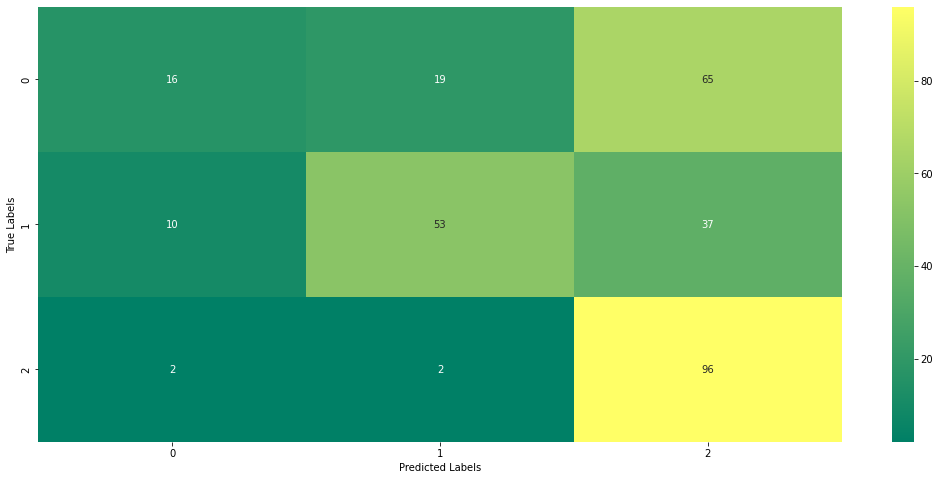

In [51]:
y_svc_hat=clf_svc.predict(x_te_prep[:,-1000:])
print_metrics(y_test,y_svc_hat)


In [52]:
print("SVC count_vectorizer report:\n",classification_report(y_test,y_svc_hat),"\n","*"*50)
print("RF count_vectorizer report:\n",classification_report(y_test,y_rf_hat),"\n","*"*50)
print("LR count_vectorizer report:\n",classification_report(y_test,y_lr_hat),"\n","*"*50)

SVC count_vectorizer report:
               precision    recall  f1-score   support

           0       0.57      0.16      0.25       100
           1       0.72      0.53      0.61       100
           2       0.48      0.96      0.64       100

    accuracy                           0.55       300
   macro avg       0.59      0.55      0.50       300
weighted avg       0.59      0.55      0.50       300
 
 **************************************************
RF count_vectorizer report:
               precision    recall  f1-score   support

           0       0.59      0.39      0.47       100
           1       0.77      0.50      0.61       100
           2       0.57      0.96      0.71       100

    accuracy                           0.62       300
   macro avg       0.64      0.62      0.60       300
weighted avg       0.64      0.62      0.60       300
 
 **************************************************
LR count_vectorizer report:
               precision    recall  f1-score 

In [53]:
#std_x_tr
#std_x_te
tf_idf = TfidfVectorizer(ngram_range=(1, 3), max_features = 1000, binary=True, smooth_idf=False)
x_tfidf = tf_idf.fit_transform(X)

In [54]:
x_tr_tf=x_tfidf.toarray()[:900,:]
x_te_tf=x_tfidf.toarray()[900:,:]

In [55]:
x_tr2_tf=np.concatenate((std_x_tr,x_tr_tf),axis=1)
x_te2_tf=np.concatenate((std_x_te,x_te_tf),axis=1)

In [56]:
x_tr2_tf.shape

(900, 1005)

In [57]:
from sklearn.model_selection import GridSearchCV
clf_svc = GridSearchCV(svm.SVC(gamma='auto'),{
    'C':[1,5,10,15,20,30,50],
    'kernel': ['rbf','linear','sigmoid','poly'],
    'max_iter':[1,5,10,20,100]
}, cv= 5)
clf_svc.fit(x_tr2_tf[:,-1000:],y_train)

GridSearchCV(cv=5, estimator=SVC(gamma='auto'),
             param_grid={'C': [1, 5, 10, 15, 20, 30, 50],
                         'kernel': ['rbf', 'linear', 'sigmoid', 'poly'],
                         'max_iter': [1, 5, 10, 20, 100]})

In [58]:
print(clf_svc.best_params_,clf_svc.best_score_)

{'C': 50, 'kernel': 'rbf', 'max_iter': 100} 0.6433333333333333


In [59]:
#from sklearn.model_selection import GridSearchCV
clf_svc_2 = GridSearchCV(svm.SVC(gamma='auto'),{
    'C':[1,5,10,15,20,30,50],
    'kernel': ['rbf','linear','sigmoid','poly'],
    'max_iter':[1,5,10,20,100]
}, cv= 5)
clf_svc_2.fit(x_tr2_tf[:,:],y_train)
print(clf_svc.best_params_,clf_svc.best_score_)

{'C': 50, 'kernel': 'rbf', 'max_iter': 100} 0.6433333333333333


In [60]:
print(clf_svc_2.best_params_,clf_svc_2.best_score_)

{'C': 5, 'kernel': 'linear', 'max_iter': 100} 0.9922222222222222


In [61]:
clf_rf=GridSearchCV(RandomForestClassifier(n_estimators=300),{'max_depth':[3,4,5],
                                                              'max_features':['sqrt','log2'],
                                                              'criterion':['gini','entropy','logloss']},cv=5)
clf_rf.fit(x_tr2_tf[:,-1000:],y_train)
print(clf_rf.best_params_)
print(clf_rf.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt'}
0.6222222222222222


In [62]:
clf_rf_2=GridSearchCV(RandomForestClassifier(n_estimators=300),{'max_depth':[3,4,5],
                                                              'max_features':['sqrt','log2'],
                                                              'criterion':['gini','entropy','logloss']},cv=5)
clf_rf_2.fit(x_tr2_tf[:,:],y_train)
print(clf_rf_2.best_params_)
print(clf_rf_2.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt'}
0.8322222222222221


In [63]:
clf_lr=GridSearchCV(LogisticRegression(random_state=0,max_iter=200),{'solver':['newton-cg','sag','saga','lbfgs']},cv=5)
clf_lr.fit(x_tr2_tf[:,-1000:],y_train)
print(clf_lr.best_params_)
print(clf_lr.best_score_)

{'solver': 'newton-cg'}
0.65


In [64]:
clf_lr_2=GridSearchCV(LogisticRegression(random_state=0,max_iter=200),{'solver':['newton-cg','sag','saga','lbfgs']},cv=5)
clf_lr_2.fit(x_tr2_tf[:,:],y_train)
print(clf_lr.best_params_)
print(clf_lr.best_score_)

{'solver': 'newton-cg'}
0.65


In [65]:
y_hat_clf_lr=clf_lr.predict(x_te2_tf[:,-1000:])
print("LR ONLY TEXT FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_lr),"\n","*"*50)
y_hat_clf_lr_2=clf_lr_2.predict(x_te2_tf[:,:])
print("LR ALL FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_lr_2),"\n","*"*50)
y_hat_clf_svc=clf_svc.predict(x_te2_tf[:,-1000:])
print("SVC ONLY TEXT FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_svc),"\n","*"*50)
y_hat_clf_svc_2=clf_svc_2.predict(x_te2_tf[:,:])
print("SVC ALL FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_svc_2),"\n","*"*50)
y_hat_clf_rf=clf_rf.predict(x_te2_tf[:,-1000:])
print("RF ONLY TEXT FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_rf),"\n","*"*50)
y_hat_clf_rf_2=clf_rf_2.predict(x_te2_tf[:,:])
print("RF ALL FEATURES - TFIDF REPORT:\n",classification_report(y_test,y_hat_clf_rf_2),"\n","*"*50)

LR ONLY TEXT FEATURES - TFIDF REPORT:
               precision    recall  f1-score   support

           0       0.60      0.48      0.53       100
           1       0.65      0.73      0.69       100
           2       0.81      0.87      0.84       100

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300
 
 **************************************************
LR ALL FEATURES - TFIDF REPORT:
               precision    recall  f1-score   support

           0       0.99      0.96      0.97       100
           1       0.96      1.00      0.98       100
           2       1.00      0.99      0.99       100

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300
 
 **************************************************
SVC ONLY TEXT FEATURES - TFIDF REPORT:
               precis

ROC_AUC_DICT = {0: 0.6599999999999999, 1: 0.7675, 2: 0.8825000000000001}
 ****************************************
f1_score macro =  0.6861836800516046 
 **************************************************
f1_score micro (or accuracy) =  0.6933333333333334 
 **************************************************
PRECISION =  0.6857804232804233  AVERAGED PRECSION =  0.6857804232804233 
 **************************************************
RECALL =  0.6933333333333334  AVERAGED RECALL =  0.6933333333333334 
 **************************************************
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       100
           1       0.65      0.73      0.69       100
           2       0.81      0.87      0.84       100

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300
 
 **************************************************


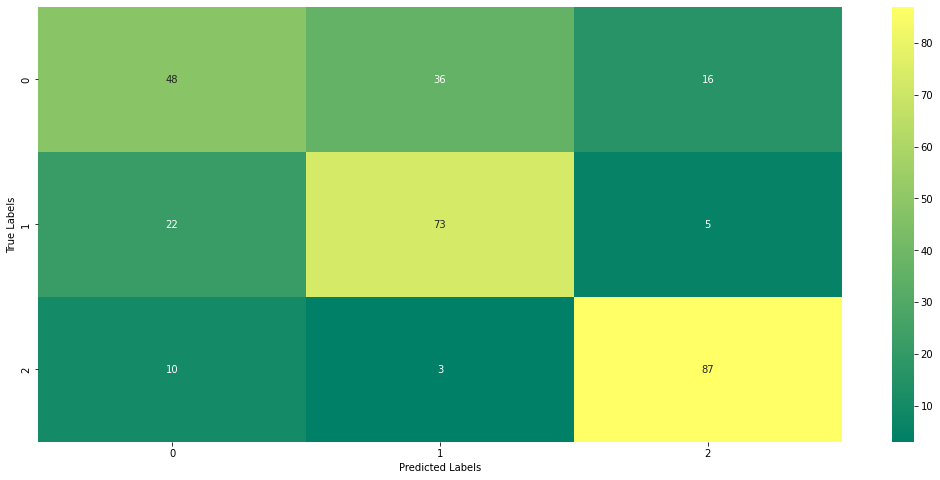

In [66]:
print_metrics(y_test,y_hat_clf_lr)

ROC_AUC_DICT = {0: 0.9774999999999999, 1: 0.99, 2: 0.995}
 ****************************************
f1_score macro =  0.983328773524902 
 **************************************************
f1_score micro (or accuracy) =  0.9833333333333333 
 **************************************************
PRECISION =  0.9837430610626487  AVERAGED PRECSION =  0.9837430610626487 
 **************************************************
RECALL =  0.9833333333333333  AVERAGED RECALL =  0.9833333333333333 
 **************************************************
              precision    recall  f1-score   support

           0       0.99      0.96      0.97       100
           1       0.96      1.00      0.98       100
           2       1.00      0.99      0.99       100

    accuracy                           0.98       300
   macro avg       0.98      0.98      0.98       300
weighted avg       0.98      0.98      0.98       300
 
 **************************************************


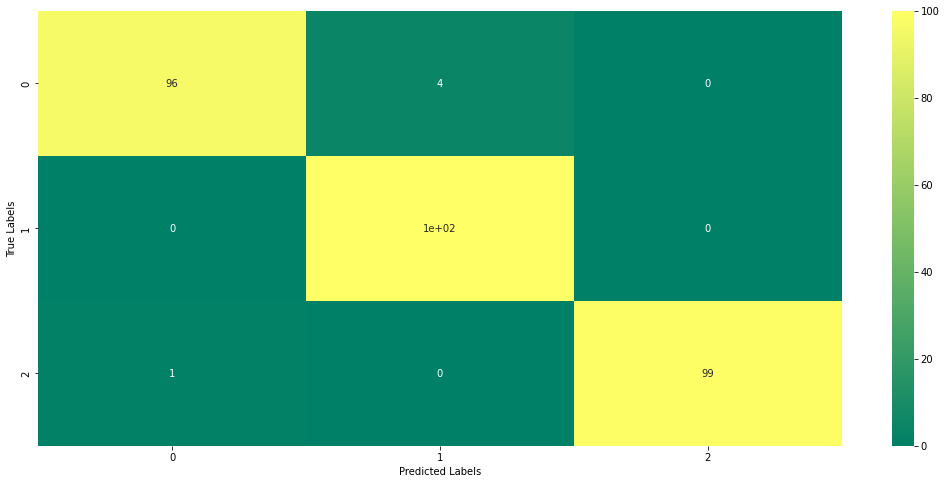

In [67]:
print_metrics(y_test,y_hat_clf_lr_2)

ROC_AUC_DICT = {0: 0.6075, 1: 0.7825, 2: 0.8525}
 ****************************************
f1_score macro =  0.6322175381780619 
 **************************************************
f1_score micro (or accuracy) =  0.6633333333333333 
 **************************************************
PRECISION =  0.6576934936786926  AVERAGED PRECSION =  0.6576934936786926 
 **************************************************
RECALL =  0.6633333333333333  AVERAGED RECALL =  0.6633333333333333 
 **************************************************
              precision    recall  f1-score   support

           0       0.64      0.30      0.41       100
           1       0.66      0.76      0.71       100
           2       0.67      0.93      0.78       100

    accuracy                           0.66       300
   macro avg       0.66      0.66      0.63       300
weighted avg       0.66      0.66      0.63       300
 
 **************************************************


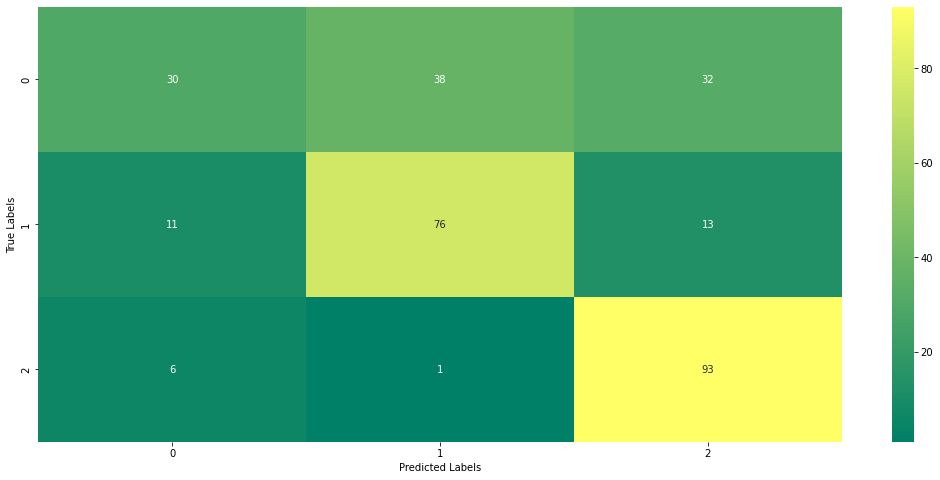

In [68]:
print_metrics(y_test,y_hat_clf_svc)

ROC_AUC_DICT = {0: 0.98, 1: 0.99, 2: 1.0}
 ****************************************
f1_score macro =  0.9866613311991462 
 **************************************************
f1_score micro (or accuracy) =  0.9866666666666668 
 **************************************************
PRECISION =  0.9871794871794873  AVERAGED PRECSION =  0.9871794871794873 
 **************************************************
RECALL =  0.9866666666666667  AVERAGED RECALL =  0.9866666666666667 
 **************************************************
              precision    recall  f1-score   support

           0       1.00      0.96      0.98       100
           1       0.96      1.00      0.98       100
           2       1.00      1.00      1.00       100

    accuracy                           0.99       300
   macro avg       0.99      0.99      0.99       300
weighted avg       0.99      0.99      0.99       300
 
 **************************************************


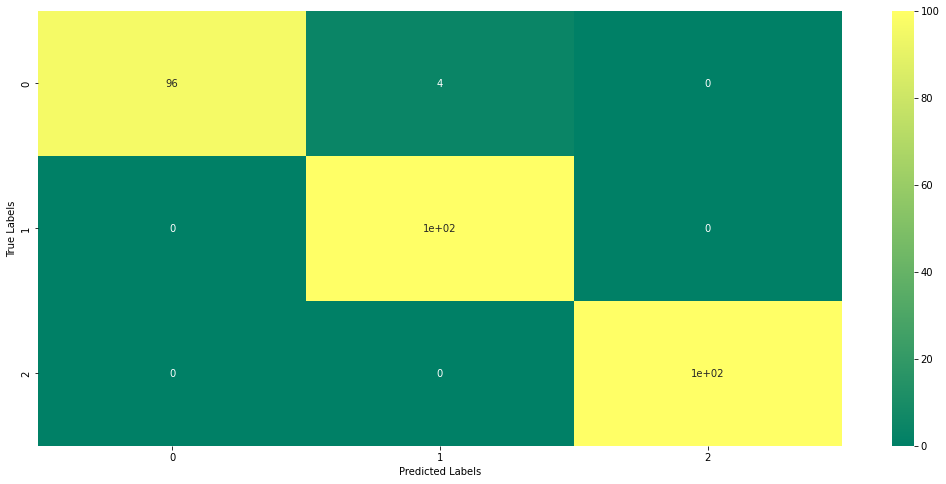

In [69]:
print_metrics(y_test,y_hat_clf_svc_2)

ROC_AUC_DICT = {0: 0.6125, 1: 0.7450000000000001, 2: 0.7725000000000001}
 ****************************************
f1_score macro =  0.6116121009085833 
 **************************************************
f1_score micro (or accuracy) =  0.6133333333333333 
 **************************************************
PRECISION =  0.6240021265284423  AVERAGED PRECSION =  0.6240021265284423 
 **************************************************
RECALL =  0.6133333333333333  AVERAGED RECALL =  0.6133333333333333 
 **************************************************
              precision    recall  f1-score   support

           0       0.48      0.48      0.48       100
           1       0.76      0.58      0.66       100
           2       0.62      0.78      0.69       100

    accuracy                           0.61       300
   macro avg       0.62      0.61      0.61       300
weighted avg       0.62      0.61      0.61       300
 
 **************************************************


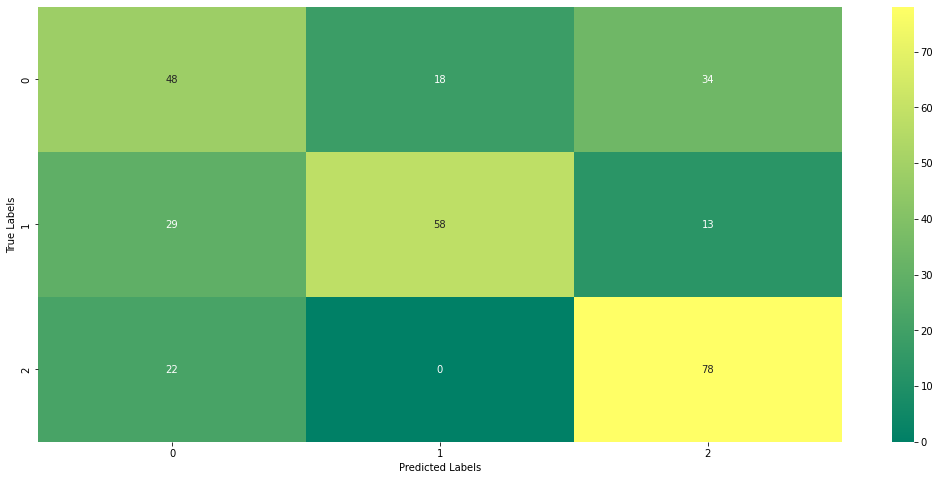

In [70]:
print_metrics(y_test,y_hat_clf_rf)

ROC_AUC_DICT = {0: 0.7949999999999999, 1: 0.8449999999999999, 2: 0.9099999999999999}
 ****************************************
f1_score macro =  0.7978770227714004 
 **************************************************
f1_score micro (or accuracy) =  0.8000000000000002 
 **************************************************
PRECISION =  0.8070174707981346  AVERAGED PRECSION =  0.8070174707981346 
 **************************************************
RECALL =  0.8  AVERAGED RECALL =  0.8 
 **************************************************
              precision    recall  f1-score   support

           0       0.73      0.72      0.73       100
           1       0.90      0.73      0.81       100
           2       0.79      0.95      0.86       100

    accuracy                           0.80       300
   macro avg       0.81      0.80      0.80       300
weighted avg       0.81      0.80      0.80       300
 
 **************************************************


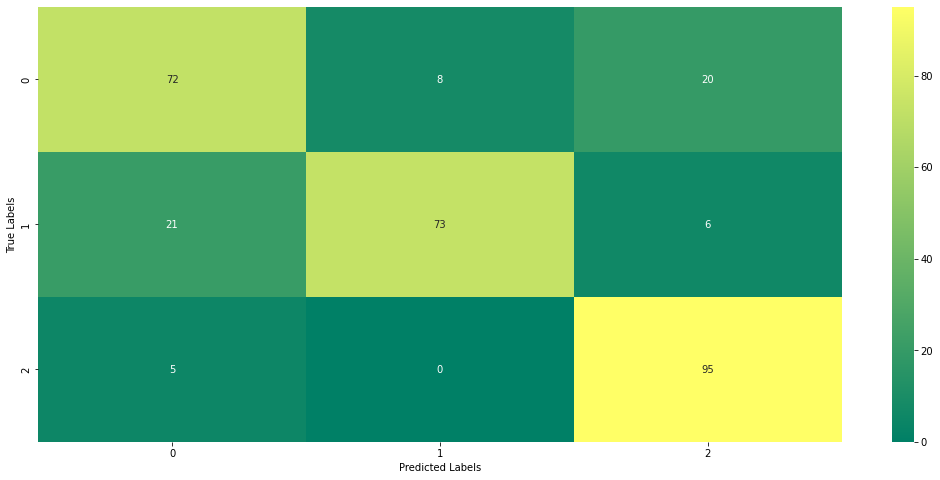

In [71]:
print_metrics(y_test,y_hat_clf_rf_2)

{'n_estimators': 100}
0.5344444444444444
ROC_AUC_DICT = {0: 0.5549999999999999, 1: 0.6975, 2: 0.765}
 ****************************************
f1_score macro =  0.5291221056138596 
 **************************************************
f1_score micro (or accuracy) =  0.5633333333333334 
 **************************************************
PRECISION =  0.5677600327600328  AVERAGED PRECSION =  0.5677600327600328 
 **************************************************
RECALL =  0.5633333333333334  AVERAGED RECALL =  0.5633333333333334 
 **************************************************
              precision    recall  f1-score   support

           0       0.48      0.24      0.32       100
           1       0.69      0.51      0.59       100
           2       0.53      0.94      0.68       100

    accuracy                           0.56       300
   macro avg       0.57      0.56      0.53       300
weighted avg       0.57      0.56      0.53       300
 
 *********************************

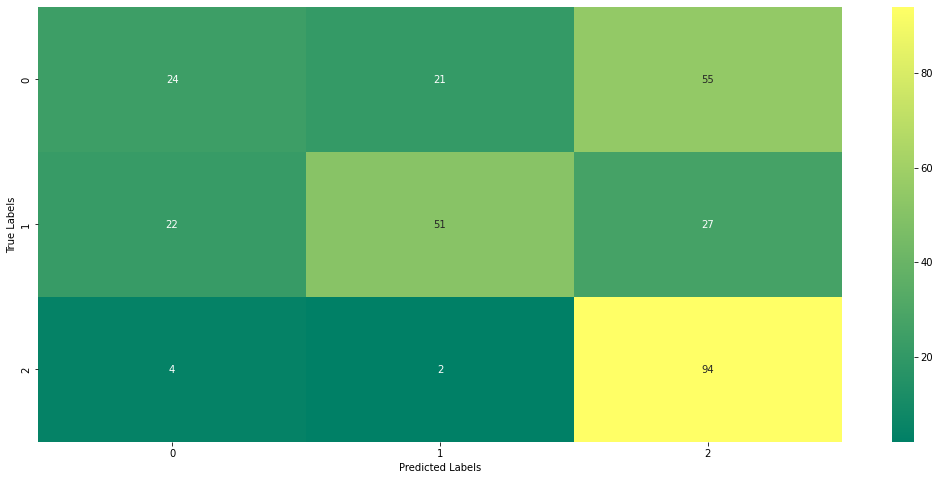

In [72]:
DTC=DecisionTreeClassifier(max_depth=2)
AB = AdaBoostClassifier(base_estimator=DTC ,learning_rate=0.01)
clf_AB_1=GridSearchCV(AB,{'n_estimators':[5,10,20,25,100]},cv=5)

# Printing all the parameters of Adaboost
#print(clf)

# Creating the model on Training Data
clf_AB_1.fit(x_tr_prep[:,-1000:],y_train)
y_AB_1_hat=clf_AB_1.predict(x_te_prep[:,-1000:])
AB_1=classification_report(y_test,y_AB_1_hat)

#clf_rf_2.fit(x_tr_prep[:,:],y_train)
print(clf_AB_1.best_params_)
print(clf_AB_1.best_score_)
print_metrics(y_test,y_AB_1_hat)

{'n_estimators': 5}
0.9988888888888889
ROC_AUC_DICT = {0: 1.0, 1: 1.0, 2: 1.0}
 ****************************************
f1_score macro =  1.0 
 **************************************************
f1_score micro (or accuracy) =  1.0 
 **************************************************
PRECISION =  1.0  AVERAGED PRECSION =  1.0 
 **************************************************
RECALL =  1.0  AVERAGED RECALL =  1.0 
 **************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300
 
 **************************************************


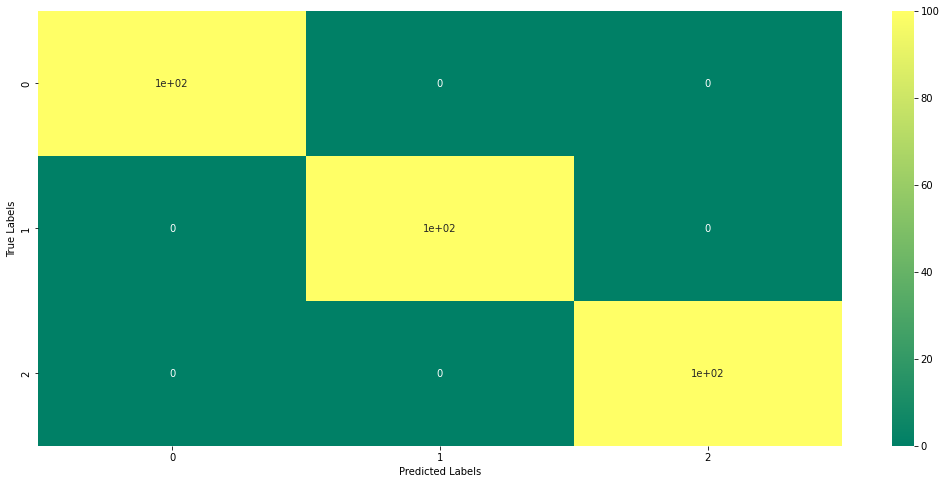

In [73]:
clf_AB_1.fit(x_tr_prep[:,:],y_train)
print(clf_AB_1.best_params_)
print(clf_AB_1.best_score_)
y_AB_2_hat=clf_AB_1.predict(x_te_prep[:,:])
#print("DT ALL FEATURES - CV REPORT:\n",classification_report(y_test,y_AB_2_hat),"\n","*"*50)
AB_2=classification_report(y_test,y_AB_2_hat)
print_metrics(y_test,y_AB_2_hat)

{'n_estimators': 100}
0.5911111111111111
ROC_AUC_DICT = {0: 0.6449999999999999, 1: 0.7325, 2: 0.7675}
 ****************************************
f1_score macro =  0.6231319375369951 
 **************************************************
f1_score micro (or accuracy) =  0.62 
 **************************************************
PRECISION =  0.6418344961107101  AVERAGED PRECSION =  0.6418344961107101 
 **************************************************
RECALL =  0.62  AVERAGED RECALL =  0.62 
 **************************************************
              precision    recall  f1-score   support

           0       0.49      0.60      0.54       100
           1       0.76      0.55      0.64       100
           2       0.67      0.71      0.69       100

    accuracy                           0.62       300
   macro avg       0.64      0.62      0.62       300
weighted avg       0.64      0.62      0.62       300
 
 **************************************************


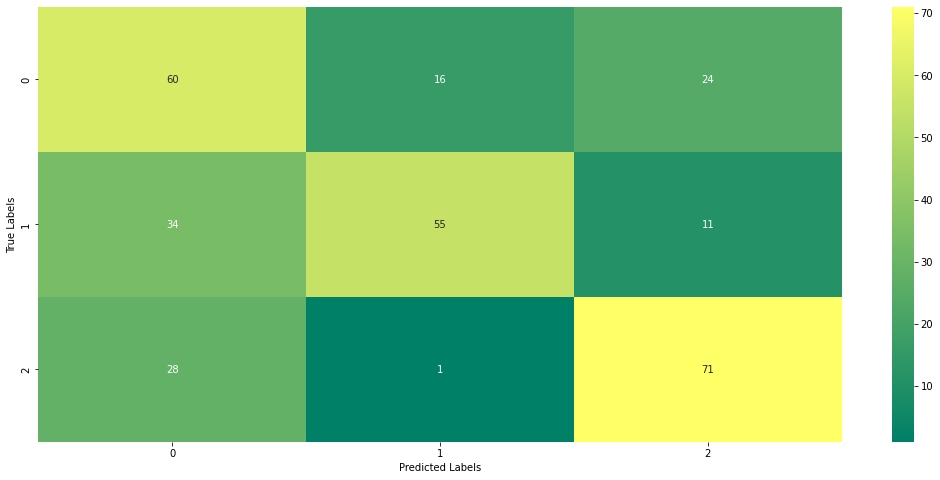

In [74]:
clf_AB_1.fit(x_tr2_tf[:,-1000:],y_train)
print(clf_AB_1.best_params_)
print(clf_AB_1.best_score_)
y_AB_3_hat=clf_AB_1.predict(x_te2_tf[:,-1000:])
#print("DT ALL FEATURES - CV REPORT:\n",classification_report(y_test,y_AB_2_hat),"\n","*"*50)
AB_3=classification_report(y_test,y_AB_3_hat)
print_metrics(y_test,y_AB_3_hat)

{'n_estimators': 5}
0.9988888888888889
ROC_AUC_DICT = {0: 1.0, 1: 1.0, 2: 1.0}
 ****************************************
f1_score macro =  1.0 
 **************************************************
f1_score micro (or accuracy) =  1.0 
 **************************************************
PRECISION =  1.0  AVERAGED PRECSION =  1.0 
 **************************************************
RECALL =  1.0  AVERAGED RECALL =  1.0 
 **************************************************
              precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300
 
 **************************************************


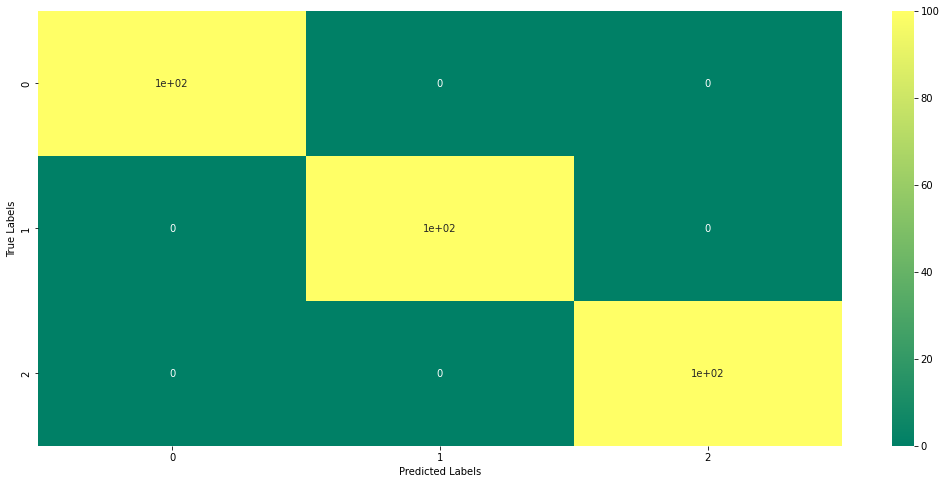

In [75]:
clf_AB_1.fit(x_tr2_tf[:,:],y_train)
print(clf_AB_1.best_params_)
print(clf_AB_1.best_score_)
y_AB_4_hat=clf_AB_1.predict(x_te2_tf[:,:])
#print("DT ALL FEATURES - CV REPORT:\n",classification_report(y_test,y_AB_2_hat),"\n","*"*50)
AB_4=classification_report(y_test,y_AB_4_hat)
print_metrics(y_test,y_AB_4_hat)

In [76]:
print("DT TEXT FEATURES - CV REPORT:\n",AB_1,"\n","*"*50)
print("DT ALL FEATURES - CV REPORT:\n",AB_2,"\n","*"*50)
print("DT TEXT FEATURES - TFIDF REPORT:\n",AB_3,"\n","*"*50)
print("DT ALL FEATURES - TFIDF REPORT:\n",AB_4,"\n","*"*50)

DT TEXT FEATURES - CV REPORT:
               precision    recall  f1-score   support

           0       0.48      0.24      0.32       100
           1       0.69      0.51      0.59       100
           2       0.53      0.94      0.68       100

    accuracy                           0.56       300
   macro avg       0.57      0.56      0.53       300
weighted avg       0.57      0.56      0.53       300
 
 **************************************************
DT ALL FEATURES - CV REPORT:
               precision    recall  f1-score   support

           0       1.00      1.00      1.00       100
           1       1.00      1.00      1.00       100
           2       1.00      1.00      1.00       100

    accuracy                           1.00       300
   macro avg       1.00      1.00      1.00       300
weighted avg       1.00      1.00      1.00       300
 
 **************************************************
DT TEXT FEATURES - TFIDF REPORT:
               precision    recall  f1

In [77]:
# Baseline scores (assuming the same prediction for all data samples)
from sklearn.metrics import mean_squared_error
rmse_test = mean_squared_error(y_test, y_hat_clf_lr, squared=False)
#rmse_bs_train = mean_squared_error(y_train, [np.mean(y_train)]*len(y_train), squared=False)
rmse_bs_test = mean_squared_error(y_test, [np.mean(y_train)]*len(y_test), squared=False)
print(f"RMSE baseline score for test {round(rmse_bs_test,3)} points")

RMSE baseline score for test 0.816 points


## ABLATION -removing Pagesnumber feature

In [78]:
std_x_tr_2=scaler.fit_transform(x_train[['age','Language','Authors','Publisher']].to_numpy())
std_x_tr_2

array([[-0.22549925, -0.44087278, -0.6383759 , -1.35289118],
       [ 0.73180889, -0.44087278, -0.21472296,  1.39534493],
       [ 0.73180889, -0.44087278, -1.55168293, -0.30650797],
       ...,
       [-1.18280739, -0.44087278, -0.85418955, -0.44972219],
       [-1.18280739, -0.44087278,  0.98667267, -1.17136577],
       [-0.22549925,  0.83564895, -1.31314116,  0.41207072]])

In [80]:
std_x_te_2=scaler.fit_transform(x_test[['age','Language','Authors','Publisher']].to_numpy())
std_x_te_2

array([[ 0.68133929, -0.36399793,  0.56384   ,  0.36613274],
       [ 0.68133929, -0.36399793, -0.70411603,  1.44966222],
       [ 0.68133929, -0.36399793, -0.28942413, -0.88670286],
       ...,
       [ 0.68133929, -0.36399793, -1.57582189, -0.54083255],
       [-1.23792631, -0.36399793,  0.25594207, -1.48823577],
       [ 0.68133929, -0.36399793,  0.56384   ,  1.61704272]])

In [81]:
x_tr_prep_A=np.concatenate((std_x_tr_2,x_tr_cv),axis=1)
x_te_prep_A=np.concatenate((std_x_te_2,x_te_cv),axis=1)

In [98]:
clf_svc.fit(x_tr_prep_A[:,-1000:],y_train)
print(clf_svc.best_params_,clf_svc.best_score_)

{'C': 15, 'kernel': 'sigmoid', 'max_iter': 100} 0.538888888888889


In [99]:
clf_svc_2.fit(x_tr_prep_A[:,:],y_train)
print(clf_svc_2.best_params_)
print(clf_svc_2.best_score_)

{'C': 50, 'kernel': 'rbf', 'max_iter': 100}
0.5211111111111111


In [100]:
clf_rf.fit(x_tr_prep_A[:,-1000:],y_train)
print(clf_rf.best_params_)
print(clf_rf.best_score_)

{'criterion': 'entropy', 'max_depth': 4, 'max_features': 'log2'}
0.5844444444444444


In [101]:
clf_rf_2.fit(x_tr_prep_A[:,:],y_train)
print(clf_rf_2.best_params_)
print(clf_rf_2.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'log2'}
0.5877777777777777


In [102]:
clf_lr.fit(x_tr_prep_A[:,-1000:],y_train)
print(clf_lr.best_params_)
print(clf_lr.best_score_)

{'solver': 'newton-cg'}
0.5911111111111111


In [103]:
clf_lr_2.fit(x_tr_prep_A[:,:],y_train)
print(clf_lr.best_params_)
print(clf_lr.best_score_)

{'solver': 'newton-cg'}
0.5911111111111111


In [104]:
##OUTPUT
y_hat_clf_lrA=clf_lr.predict(x_te_prep_A[:,-1000:])
print("LR ONLY TEXT FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_lrA),"\n","*"*50)
y_hat_clf_lr_2A=clf_lr_2.predict(x_te_prep_A[:,:])
print("LR ALL FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_lr_2A),"\n","*"*50)
y_hat_clf_svcA=clf_svc.predict(x_te_prep_A[:,-1000:])
print("SVC ONLY TEXT FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_svcA),"\n","*"*50)
y_hat_clf_svc_2A=clf_svc_2.predict(x_te_prep_A[:,:])
print("SVC ALL FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_svc_2A),"\n","*"*50)
y_hat_clf_rfA=clf_rf.predict(x_te_prep_A[:,-1000:])
print("RF ONLY TEXT FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_rfA),"\n","*"*50)
y_hat_clf_rf_2A=clf_rf_2.predict(x_te_prep_A[:,:])
print("RF ALL FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_rf_2A),"\n","*"*50)

LR ONLY TEXT FEATURES - CV-ABLATION-REPORT:
               precision    recall  f1-score   support

           0       0.50      0.42      0.46       100
           1       0.65      0.66      0.66       100
           2       0.69      0.79      0.73       100

    accuracy                           0.62       300
   macro avg       0.61      0.62      0.62       300
weighted avg       0.61      0.62      0.62       300
 
 **************************************************
LR ALL FEATURES - CV-ABLATION-REPORT:
               precision    recall  f1-score   support

           0       0.52      0.43      0.47       100
           1       0.63      0.64      0.64       100
           2       0.71      0.82      0.76       100

    accuracy                           0.63       300
   macro avg       0.62      0.63      0.62       300
weighted avg       0.62      0.63      0.62       300
 
 **************************************************
SVC ONLY TEXT FEATURES - CV-ABLATION-REPORT:
   

ROC_AUC_DICT = {0: 0.605, 1: 0.7424999999999999, 2: 0.8050000000000002}
 ****************************************
f1_score macro =  0.6160406259903718 
 **************************************************
f1_score micro (or accuracy) =  0.6233333333333333 
 **************************************************
PRECISION =  0.6134739560912613  AVERAGED PRECSION =  0.6134739560912613 
 **************************************************
RECALL =  0.6233333333333333  AVERAGED RECALL =  0.6233333333333333 
 **************************************************
              precision    recall  f1-score   support

           0       0.50      0.42      0.46       100
           1       0.65      0.66      0.66       100
           2       0.69      0.79      0.73       100

    accuracy                           0.62       300
   macro avg       0.61      0.62      0.62       300
weighted avg       0.61      0.62      0.62       300
 
 **************************************************


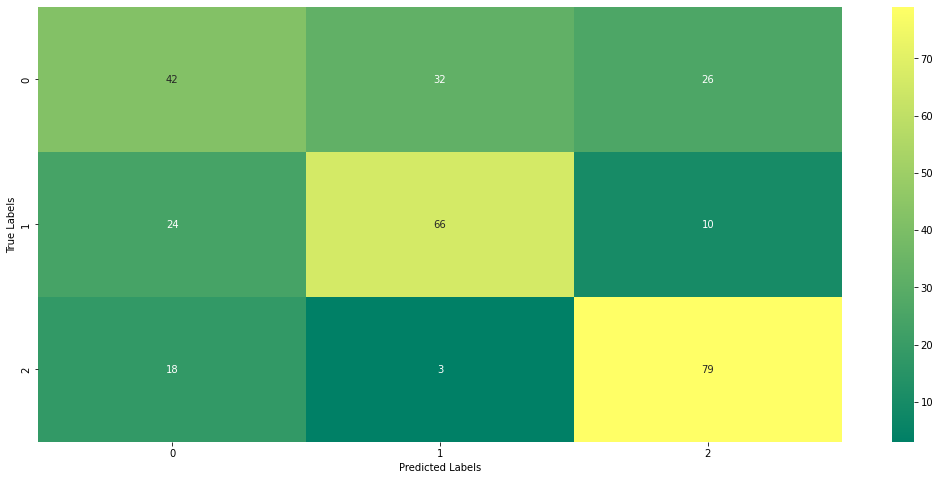

In [106]:
print_metrics(y_test,y_hat_clf_lrA)

ROC_AUC_DICT = {0: 0.615, 1: 0.7275, 2: 0.8249999999999998}
 ****************************************
f1_score macro =  0.6220068449495088 
 **************************************************
f1_score micro (or accuracy) =  0.63 
 **************************************************
PRECISION =  0.6195440690724661  AVERAGED PRECSION =  0.6195440690724661 
 **************************************************
RECALL =  0.63  AVERAGED RECALL =  0.63 
 **************************************************
              precision    recall  f1-score   support

           0       0.52      0.43      0.47       100
           1       0.63      0.64      0.64       100
           2       0.71      0.82      0.76       100

    accuracy                           0.63       300
   macro avg       0.62      0.63      0.62       300
weighted avg       0.62      0.63      0.62       300
 
 **************************************************


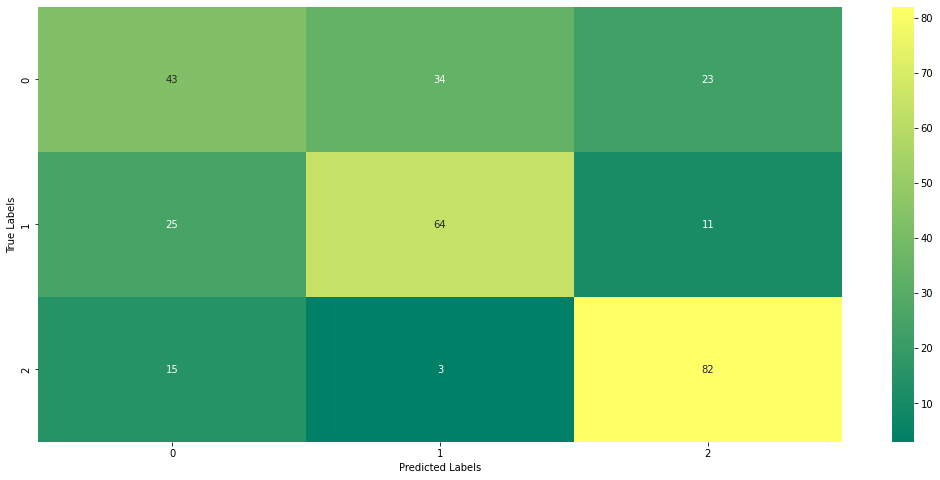

In [107]:
print_metrics(y_test,y_hat_clf_lr_2A)

ROC_AUC_DICT = {0: 0.5499999999999999, 1: 0.7125, 2: 0.725}
 ****************************************
f1_score macro =  0.5011635681040911 
 **************************************************
f1_score micro (or accuracy) =  0.55 
 **************************************************
PRECISION =  0.590831090831091  AVERAGED PRECSION =  0.590831090831091 
 **************************************************
RECALL =  0.55  AVERAGED RECALL =  0.55 
 **************************************************
              precision    recall  f1-score   support

           0       0.57      0.16      0.25       100
           1       0.72      0.53      0.61       100
           2       0.48      0.96      0.64       100

    accuracy                           0.55       300
   macro avg       0.59      0.55      0.50       300
weighted avg       0.59      0.55      0.50       300
 
 **************************************************


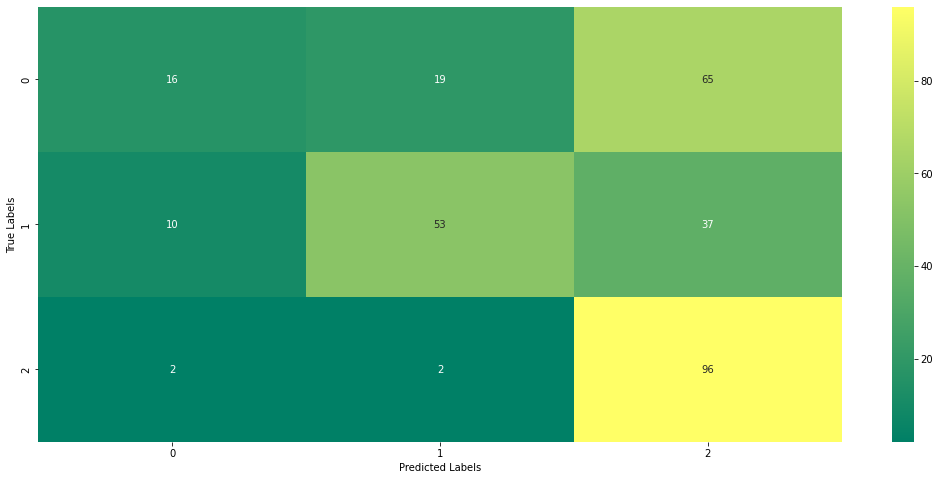

In [108]:
print_metrics(y_test,y_hat_clf_svcA)

ROC_AUC_DICT = {0: 0.54, 1: 0.6375000000000001, 2: 0.7725}
 ****************************************
f1_score macro =  0.5032671149367385 
 **************************************************
f1_score micro (or accuracy) =  0.5333333333333333 
 **************************************************
PRECISION =  0.5294603886275608  AVERAGED PRECSION =  0.5294603886275608 
 **************************************************
RECALL =  0.5333333333333333  AVERAGED RECALL =  0.5333333333333333 
 **************************************************
              precision    recall  f1-score   support

           0       0.41      0.29      0.34       100
           1       0.63      0.39      0.48       100
           2       0.55      0.92      0.69       100

    accuracy                           0.53       300
   macro avg       0.53      0.53      0.50       300
weighted avg       0.53      0.53      0.50       300
 
 **************************************************


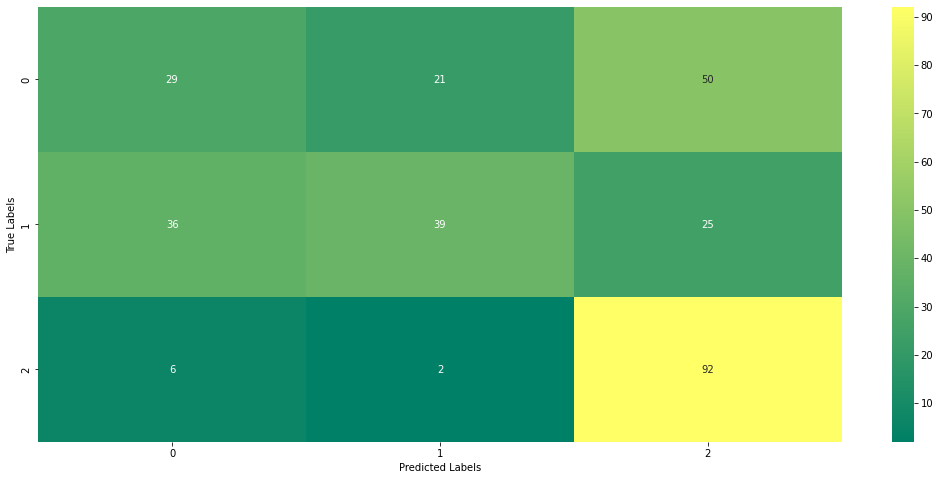

In [109]:
print_metrics(y_test,y_hat_clf_svc_2A)

ROC_AUC_DICT = {0: 0.6499999999999999, 1: 0.7449999999999999, 2: 0.7949999999999999}
 ****************************************
f1_score macro =  0.628715547863299 
 **************************************************
f1_score micro (or accuracy) =  0.64 
 **************************************************
PRECISION =  0.6677246678002393  AVERAGED PRECSION =  0.6677246678002393 
 **************************************************
RECALL =  0.64  AVERAGED RECALL =  0.64 
 **************************************************
              precision    recall  f1-score   support

           0       0.60      0.45      0.51       100
           1       0.82      0.55      0.66       100
           2       0.58      0.92      0.71       100

    accuracy                           0.64       300
   macro avg       0.67      0.64      0.63       300
weighted avg       0.67      0.64      0.63       300
 
 **************************************************


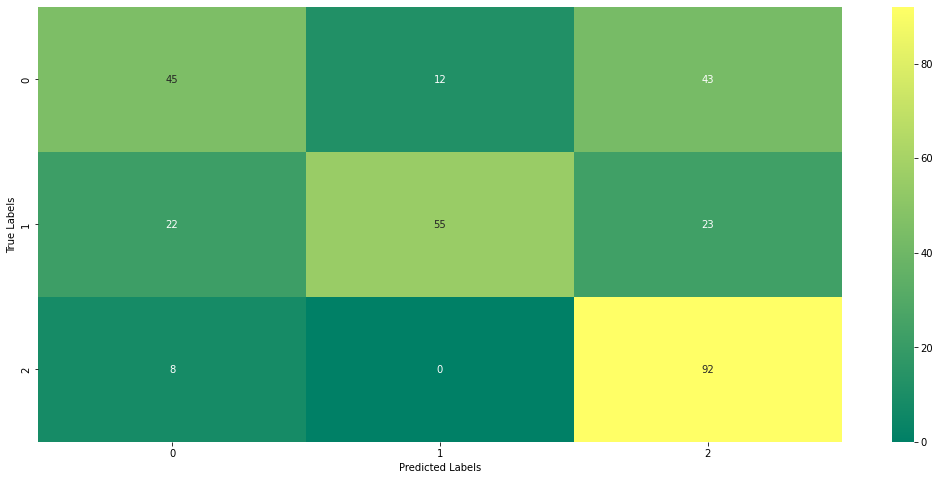

In [110]:
print_metrics(y_test,y_hat_clf_rfA)

ROC_AUC_DICT = {0: 0.6475, 1: 0.735, 2: 0.7925}
 ****************************************
f1_score macro =  0.6184283723657806 
 **************************************************
f1_score micro (or accuracy) =  0.6333333333333333 
 **************************************************
PRECISION =  0.6635600961325281  AVERAGED PRECSION =  0.6635600961325281 
 **************************************************
RECALL =  0.6333333333333333  AVERAGED RECALL =  0.6333333333333333 
 **************************************************
              precision    recall  f1-score   support

           0       0.63      0.42      0.50       100
           1       0.79      0.54      0.64       100
           2       0.57      0.94      0.71       100

    accuracy                           0.63       300
   macro avg       0.66      0.63      0.62       300
weighted avg       0.66      0.63      0.62       300
 
 **************************************************


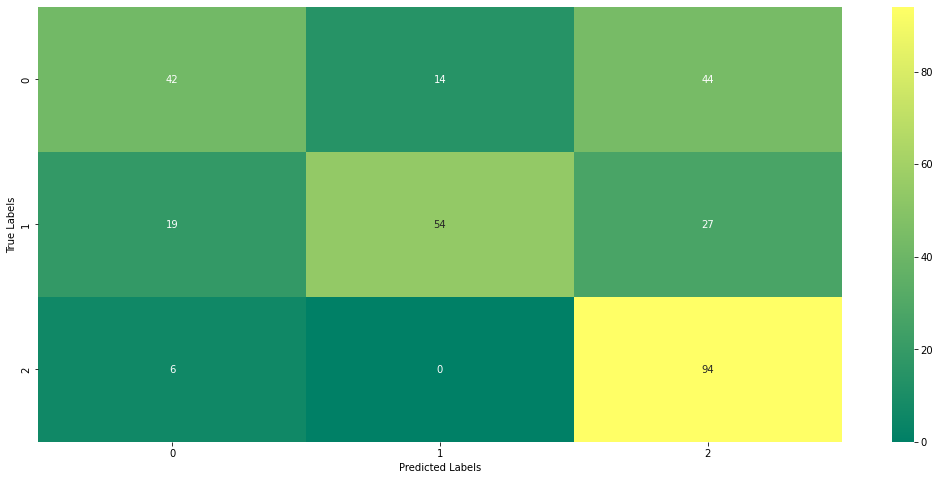

In [111]:
print_metrics(y_test,y_hat_clf_rf_2A)

In [112]:
x_tr_tf_A=np.concatenate((std_x_tr_2,x_tr_tf),axis=1)
x_te_tf_A=np.concatenate((std_x_te_2,x_te_tf),axis=1)

In [113]:
clf_rf.fit(x_tr_tf_A[:,-1000:],y_train)
print(clf_rf.best_params_)
print(clf_rf.best_score_)

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt'}
0.6277777777777778


In [114]:
clf_rf_2.fit(x_tr_tf_A[:,:],y_train)  #above output is again printed below

{'criterion': 'entropy', 'max_depth': 5, 'max_features': 'sqrt'}
0.6277777777777778


In [115]:
print(clf_rf_2.best_params_)
print(clf_rf_2.best_score_)

{'criterion': 'gini', 'max_depth': 5, 'max_features': 'sqrt'}
0.6233333333333333


In [116]:
clf_svc.fit(x_tr_tf_A[:,-1000:],y_train)
print(clf_svc.best_params_,clf_svc.best_score_)

{'C': 50, 'kernel': 'rbf', 'max_iter': 100} 0.6433333333333333


In [117]:
clf_svc_2.fit(x_tr_tf_A[:,:],y_train)
print(clf_svc_2.best_params_,clf_svc_2.best_score_)

{'C': 1, 'kernel': 'linear', 'max_iter': 100} 0.5599999999999999


In [118]:
clf_lr.fit(x_tr_tf_A[:,-1000:],y_train)
print(clf_lr.best_params_)
print(clf_lr.best_score_)

{'solver': 'newton-cg'}
0.65


In [120]:
clf_lr_2.fit(x_tr_tf_A[:,:],y_train)
print(clf_lr_2.best_params_)
print(clf_lr_2.best_score_)

{'solver': 'newton-cg'}
0.6477777777777778


In [121]:
y_hat_clf_lrAA=clf_lr.predict(x_te_tf_A[:,-1000:])
print("LR ONLY TEXT FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_lrAA),"\n","*"*50)
y_hat_clf_lr_2AA=clf_lr_2.predict(x_te_tf_A[:,:])
print("LR ALL FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_lr_2AA),"\n","*"*50)
y_hat_clf_svcAA=clf_svc.predict(x_te_tf_A[:,-1000:])
print("SVC ONLY TEXT FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_svcAA),"\n","*"*50)
y_hat_clf_svc_2AA=clf_svc_2.predict(x_te_tf_A[:,:])
print("SVC ALL FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_svc_2AA),"\n","*"*50)
y_hat_clf_rfAA=clf_rf.predict(x_te_tf_A[:,-1000:])
print("RF ONLY TEXT FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_rfAA),"\n","*"*50)
y_hat_clf_rf_2AA=clf_rf_2.predict(x_te_tf_A[:,:])
print("RF ALL FEATURES - CV-ABLATION-REPORT:\n",classification_report(y_test,y_hat_clf_rf_2AA),"\n","*"*50)

LR ONLY TEXT FEATURES - CV-ABLATION-REPORT:
               precision    recall  f1-score   support

           0       0.60      0.48      0.53       100
           1       0.65      0.73      0.69       100
           2       0.81      0.87      0.84       100

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300
 
 **************************************************
LR ALL FEATURES - CV-ABLATION-REPORT:
               precision    recall  f1-score   support

           0       0.58      0.49      0.53       100
           1       0.65      0.72      0.69       100
           2       0.81      0.85      0.83       100

    accuracy                           0.69       300
   macro avg       0.68      0.69      0.68       300
weighted avg       0.68      0.69      0.68       300
 
 **************************************************
SVC ONLY TEXT FEATURES - CV-ABLATION-REPORT:
   

ROC_AUC_DICT = {0: 0.6599999999999999, 1: 0.7675, 2: 0.8825000000000001}
 ****************************************
f1_score macro =  0.6861836800516046 
 **************************************************
f1_score micro (or accuracy) =  0.6933333333333334 
 **************************************************
PRECISION =  0.6857804232804233  AVERAGED PRECSION =  0.6857804232804233 
 **************************************************
RECALL =  0.6933333333333334  AVERAGED RECALL =  0.6933333333333334 
 **************************************************
              precision    recall  f1-score   support

           0       0.60      0.48      0.53       100
           1       0.65      0.73      0.69       100
           2       0.81      0.87      0.84       100

    accuracy                           0.69       300
   macro avg       0.69      0.69      0.69       300
weighted avg       0.69      0.69      0.69       300
 
 **************************************************


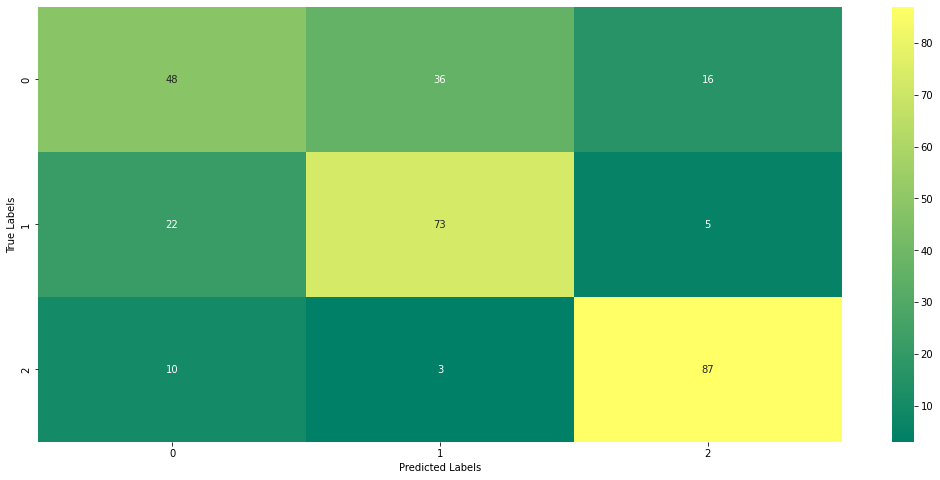

ROC_AUC_DICT = {0: 0.655, 1: 0.765, 2: 0.875}
 ****************************************
f1_score macro =  0.6815707693756474 
 **************************************************
f1_score micro (or accuracy) =  0.6866666666666666 
 **************************************************
PRECISION =  0.6801799507681859  AVERAGED PRECSION =  0.6801799507681859 
 **************************************************
RECALL =  0.6866666666666666  AVERAGED RECALL =  0.6866666666666666 
 **************************************************
              precision    recall  f1-score   support

           0       0.58      0.49      0.53       100
           1       0.65      0.72      0.69       100
           2       0.81      0.85      0.83       100

    accuracy                           0.69       300
   macro avg       0.68      0.69      0.68       300
weighted avg       0.68      0.69      0.68       300
 
 **************************************************


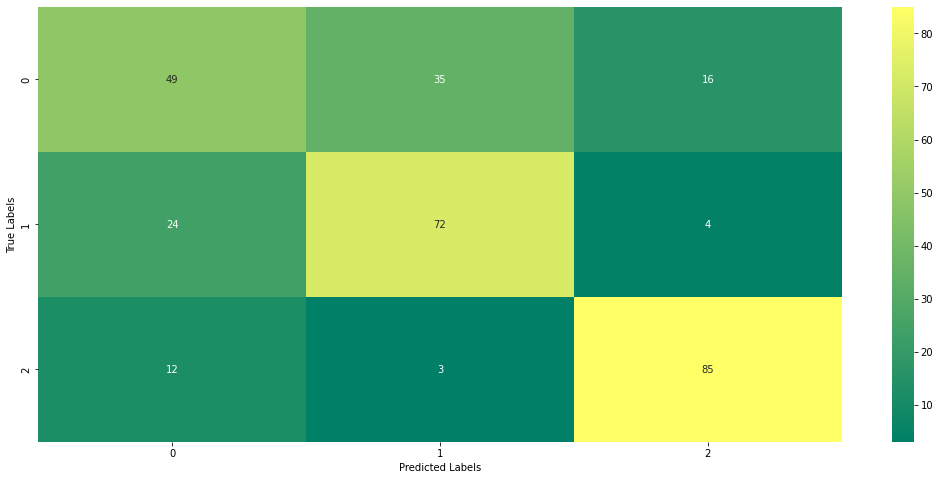

ROC_AUC_DICT = {0: 0.59, 1: 0.7225, 2: 0.78}
 ****************************************
f1_score macro =  0.5923000460271011 
 **************************************************
f1_score micro (or accuracy) =  0.5966666666666667 
 **************************************************
PRECISION =  0.5997313642756681  AVERAGED PRECSION =  0.5997313642756681 
 **************************************************
RECALL =  0.5966666666666667  AVERAGED RECALL =  0.5966666666666667 
 **************************************************
              precision    recall  f1-score   support

           0       0.46      0.44      0.45       100
           1       0.71      0.56      0.63       100
           2       0.63      0.79      0.70       100

    accuracy                           0.60       300
   macro avg       0.60      0.60      0.59       300
weighted avg       0.60      0.60      0.59       300
 
 **************************************************


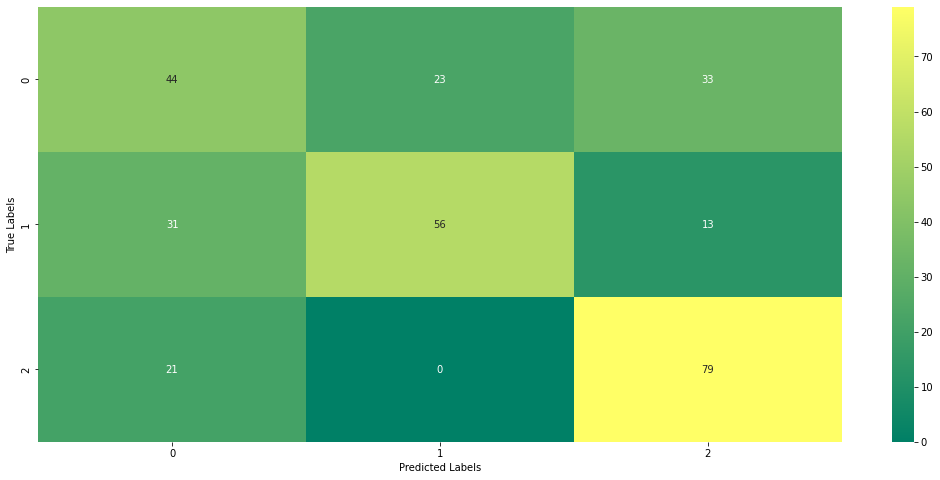

ROC_AUC_DICT = {0: 0.61, 1: 0.7325, 2: 0.795}
 ****************************************
f1_score macro =  0.6144931138034587 
 **************************************************
f1_score micro (or accuracy) =  0.6166666666666667 
 **************************************************
PRECISION =  0.6260441756415017  AVERAGED PRECSION =  0.6260441756415017 
 **************************************************
RECALL =  0.6166666666666667  AVERAGED RECALL =  0.6166666666666667 
 **************************************************
              precision    recall  f1-score   support

           0       0.48      0.49      0.48       100
           1       0.75      0.56      0.64       100
           2       0.66      0.80      0.72       100

    accuracy                           0.62       300
   macro avg       0.63      0.62      0.61       300
weighted avg       0.63      0.62      0.61       300
 
 **************************************************


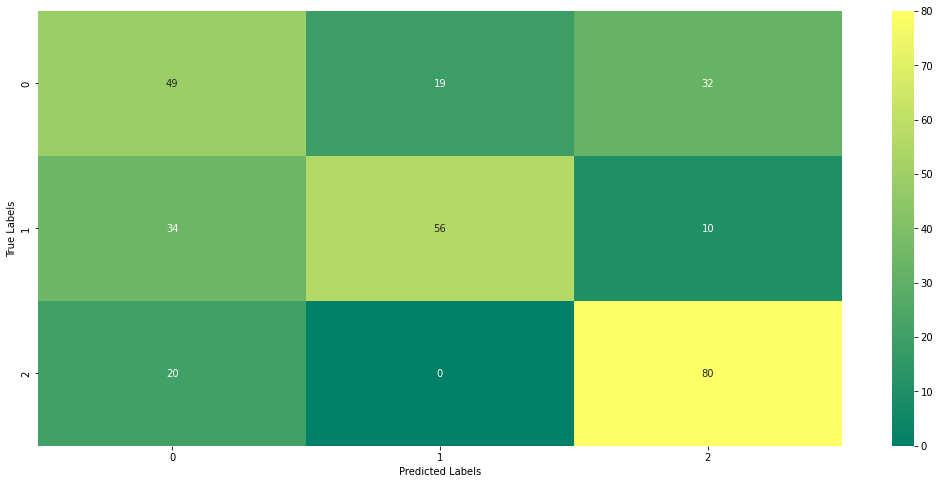

ROC_AUC_DICT = {0: 0.6075, 1: 0.7825, 2: 0.8525}
 ****************************************
f1_score macro =  0.6322175381780619 
 **************************************************
f1_score micro (or accuracy) =  0.6633333333333333 
 **************************************************
PRECISION =  0.6576934936786926  AVERAGED PRECSION =  0.6576934936786926 
 **************************************************
RECALL =  0.6633333333333333  AVERAGED RECALL =  0.6633333333333333 
 **************************************************
              precision    recall  f1-score   support

           0       0.64      0.30      0.41       100
           1       0.66      0.76      0.71       100
           2       0.67      0.93      0.78       100

    accuracy                           0.66       300
   macro avg       0.66      0.66      0.63       300
weighted avg       0.66      0.66      0.63       300
 
 **************************************************


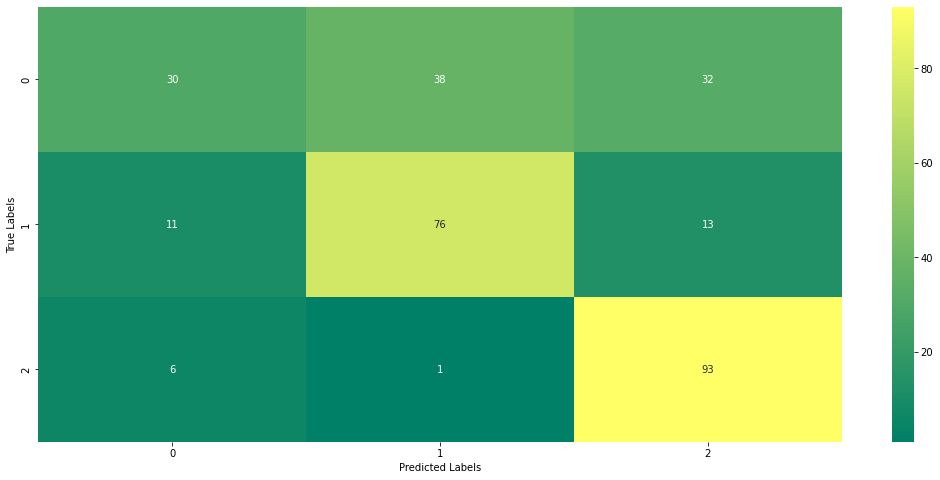

ROC_AUC_DICT = {0: 0.525, 1: 0.6325000000000001, 2: 0.6575}
 ****************************************
f1_score macro =  0.47926939028993115 
 **************************************************
f1_score micro (or accuracy) =  0.47333333333333333 
 **************************************************
PRECISION =  0.5221231607703126  AVERAGED PRECSION =  0.5221231607703126 
 **************************************************
RECALL =  0.47333333333333333  AVERAGED RECALL =  0.47333333333333333 
 **************************************************
              precision    recall  f1-score   support

           0       0.35      0.56      0.43       100
           1       0.61      0.39      0.48       100
           2       0.60      0.47      0.53       100

    accuracy                           0.47       300
   macro avg       0.52      0.47      0.48       300
weighted avg       0.52      0.47      0.48       300
 
 **************************************************


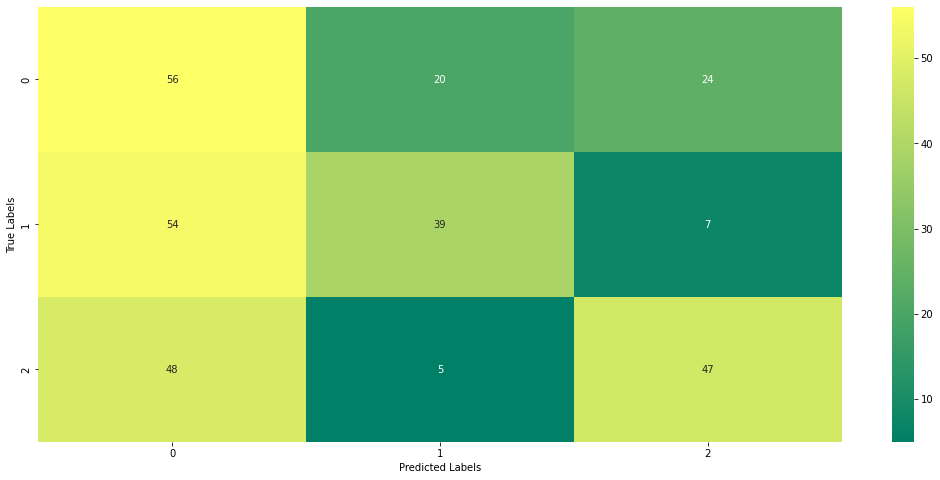

In [122]:
print_metrics(y_test,y_hat_clf_lrAA)
print_metrics(y_test,y_hat_clf_lr_2AA)
print_metrics(y_test,y_hat_clf_rfAA)
print_metrics(y_test,y_hat_clf_rf_2AA)
print_metrics(y_test,y_hat_clf_svcAA)
print_metrics(y_test,y_hat_clf_svc_2AA)

## DECISION TREE CLASSIFIER FOR ABLATION DATA

{'n_estimators': 100}
0.5322222222222222
ROC_AUC_DICT = {0: 0.5575, 1: 0.7025, 2: 0.765}
 ****************************************
f1_score macro =  0.5325309285274269 
 **************************************************
f1_score micro (or accuracy) =  0.5666666666666667 
 **************************************************
PRECISION =  0.5724067202638632  AVERAGED PRECSION =  0.5724067202638632 
 **************************************************
RECALL =  0.5666666666666667  AVERAGED RECALL =  0.5666666666666667 
 **************************************************
              precision    recall  f1-score   support

           0       0.49      0.24      0.32       100
           1       0.69      0.52      0.59       100
           2       0.53      0.94      0.68       100

    accuracy                           0.57       300
   macro avg       0.57      0.57      0.53       300
weighted avg       0.57      0.57      0.53       300
 
 *********************************************

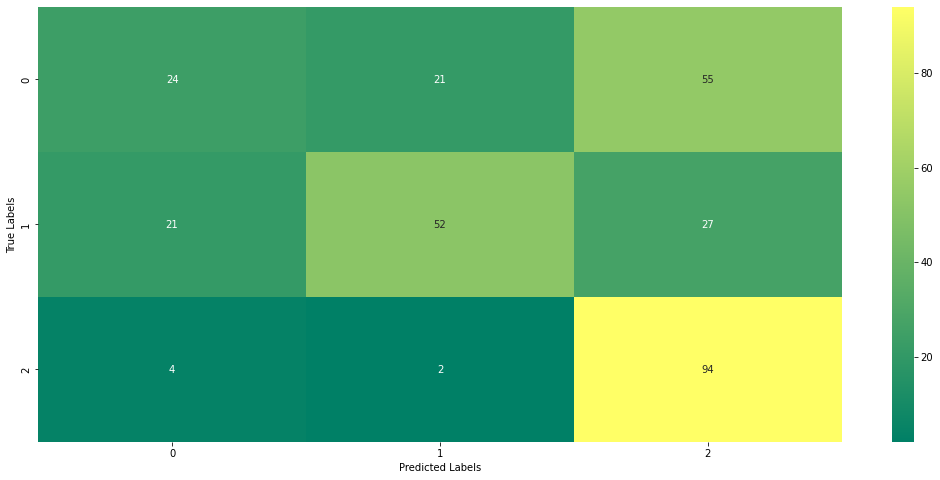

In [123]:
clf_AB_1.fit(x_tr_prep_A[:,-1000:],y_train)
print(clf_AB_1.best_params_)
print(clf_AB_1.best_score_)
y_AB_1A_hat=clf_AB_1.predict(x_te_prep_A[:,-1000:])
#print("DT ALL FEATURES - CV REPORT:\n",classification_report(y_test,y_AB_2_hat),"\n","*"*50)
#AB_1A=classification_report(y_test,y_AB_2_hat)
print_metrics(y_test,y_AB_1A_hat)

In [124]:
AB_1A=classification_report(y_test,y_AB_1A_hat)

{'n_estimators': 100}
0.5288888888888889
ROC_AUC_DICT = {0: 0.5575000000000001, 1: 0.6775, 2: 0.715}
 ****************************************
f1_score macro =  0.5251326370676579 
 **************************************************
f1_score micro (or accuracy) =  0.5333333333333333 
 **************************************************
PRECISION =  0.5610999847977104  AVERAGED PRECSION =  0.5610999847977104 
 **************************************************
RECALL =  0.5333333333333333  AVERAGED RECALL =  0.5333333333333333 
 **************************************************
              precision    recall  f1-score   support

           0       0.41      0.39      0.40       100
           1       0.74      0.43      0.54       100
           2       0.53      0.78      0.63       100

    accuracy                           0.53       300
   macro avg       0.56      0.53      0.53       300
weighted avg       0.56      0.53      0.53       300
 
 *********************************

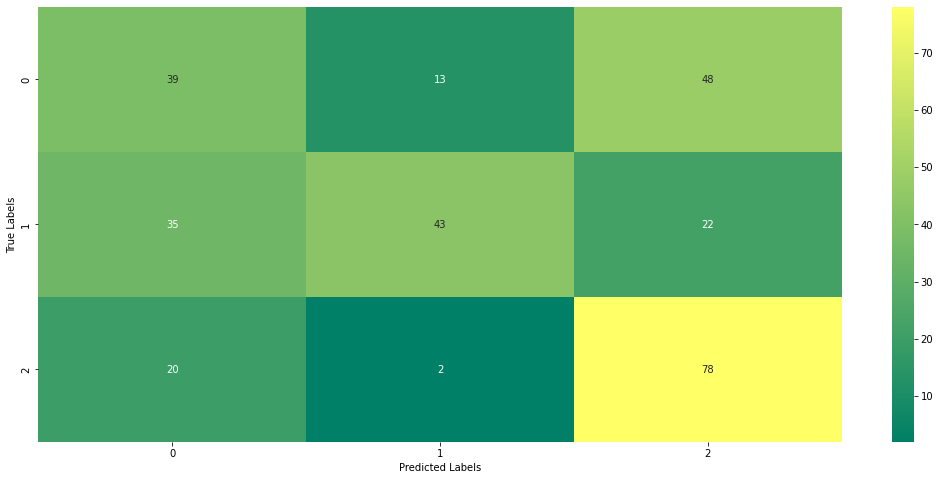

In [125]:
clf_AB_1.fit(x_tr_prep_A[:,:],y_train)
print(clf_AB_1.best_params_)
print(clf_AB_1.best_score_)
y_AB_2A_hat=clf_AB_1.predict(x_te_prep_A[:,:])
#print("DT ALL FEATURES - CV REPORT:\n",classification_report(y_test,y_AB_2_hat),"\n","*"*50)
AB_2A=classification_report(y_test,y_AB_2A_hat)
print_metrics(y_test,y_AB_2A_hat)

{'n_estimators': 100}
0.5933333333333334
ROC_AUC_DICT = {0: 0.6449999999999999, 1: 0.7325, 2: 0.7675}
 ****************************************
f1_score macro =  0.6231319375369951 
 **************************************************
f1_score micro (or accuracy) =  0.62 
 **************************************************
PRECISION =  0.6418344961107101  AVERAGED PRECSION =  0.6418344961107101 
 **************************************************
RECALL =  0.62  AVERAGED RECALL =  0.62 
 **************************************************
              precision    recall  f1-score   support

           0       0.49      0.60      0.54       100
           1       0.76      0.55      0.64       100
           2       0.67      0.71      0.69       100

    accuracy                           0.62       300
   macro avg       0.64      0.62      0.62       300
weighted avg       0.64      0.62      0.62       300
 
 **************************************************


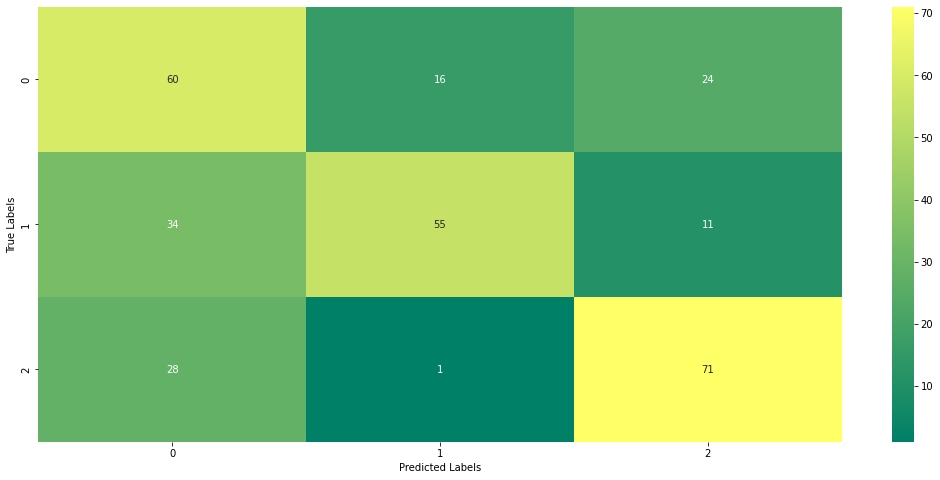

In [126]:
clf_AB_1.fit(x_tr_tf_A[:,-1000:],y_train)
print(clf_AB_1.best_params_)
print(clf_AB_1.best_score_)
y_AB_3A_hat=clf_AB_1.predict(x_te_tf_A[:,-1000:])
#print("DT ALL FEATURES - CV REPORT:\n",classification_report(y_test,y_AB_2_hat),"\n","*"*50)
AB_3A=classification_report(y_test,y_AB_3A_hat)
print_metrics(y_test,y_AB_3A_hat)

{'n_estimators': 100}
0.611111111111111
ROC_AUC_DICT = {0: 0.6575000000000001, 1: 0.7325, 2: 0.7925}
 ****************************************
f1_score macro =  0.6376364741151436 
 **************************************************
f1_score micro (or accuracy) =  0.6366666666666667 
 **************************************************
PRECISION =  0.6537980287980287  AVERAGED PRECSION =  0.6537980287980287 
 **************************************************
RECALL =  0.6366666666666667  AVERAGED RECALL =  0.6366666666666667 
 **************************************************
              precision    recall  f1-score   support

           0       0.51      0.60      0.55       100
           1       0.76      0.55      0.64       100
           2       0.68      0.76      0.72       100

    accuracy                           0.64       300
   macro avg       0.65      0.64      0.64       300
weighted avg       0.65      0.64      0.64       300
 
 *********************************

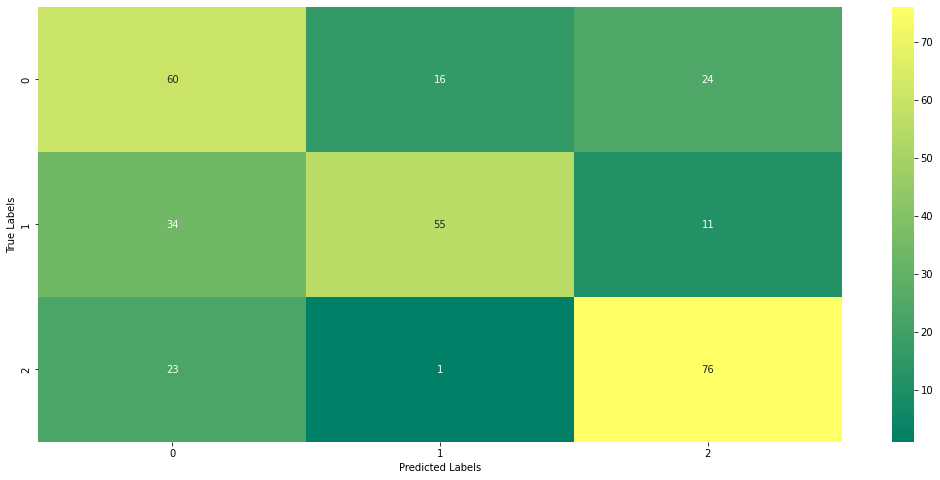

In [127]:
clf_AB_1.fit(x_tr_tf_A[:,:],y_train)
print(clf_AB_1.best_params_)
print(clf_AB_1.best_score_)
y_AB_4A_hat=clf_AB_1.predict(x_te_tf_A[:,:])
#print("DT ALL FEATURES - CV REPORT:\n",classification_report(y_test,y_AB_2_hat),"\n","*"*50)
AB_4A=classification_report(y_test,y_AB_4A_hat)
print_metrics(y_test,y_AB_4A_hat)

In [128]:
print("DT TEXT FEATURES - CV REPORT:\n",AB_1A,"\n","*"*50)
print("DT ALL FEATURES - CV REPORT:\n",AB_2A,"\n","*"*50)
print("DT TEXT FEATURES - TFIDF REPORT:\n",AB_3A,"\n","*"*50)
print("DT ALL FEATURES - TFIDF REPORT:\n",AB_4A,"\n","*"*50)

DT TEXT FEATURES - CV REPORT:
               precision    recall  f1-score   support

           0       0.49      0.24      0.32       100
           1       0.69      0.52      0.59       100
           2       0.53      0.94      0.68       100

    accuracy                           0.57       300
   macro avg       0.57      0.57      0.53       300
weighted avg       0.57      0.57      0.53       300
 
 **************************************************
DT ALL FEATURES - CV REPORT:
               precision    recall  f1-score   support

           0       0.41      0.39      0.40       100
           1       0.74      0.43      0.54       100
           2       0.53      0.78      0.63       100

    accuracy                           0.53       300
   macro avg       0.56      0.53      0.53       300
weighted avg       0.56      0.53      0.53       300
 
 **************************************************
DT TEXT FEATURES - TFIDF REPORT:
               precision    recall  f1